# **Necessary Imports**

In [ ]:
!pip install keras-tuner --quiet
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, mixed_precision
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score, recall_score, log_loss, roc_curve, roc_auc_score, brier_score_loss, precision_recall_curve, confusion_matrix,)
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import AUC
mixed_precision.set_global_policy("mixed_float16")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 11.1 MB/s eta 0:00:00


# **Loading the data**

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/final_dataset.csv")
df = df.sort_values(["match_id", "t"])
df = df.fillna(0)
df.sample(5)

,match_id,t,gold_blue,gold_red,xp_blue,xp_red,gold_diff,xp_diff,cs_lane_t1,cs_lane_t2,...,totdmgdealt_blue,totdmgdealt_red,totdmgtochamp_blue,totdmgtochamp_red,totheal_blue,totheal_red,wardsplaced_blue,wardsplaced_red,wardskilled_blue,wardskilled_red
428837,EUW1_7609683279,560,14504.0,15077.0,15438.0,16706.0,-573.0,-1268.0,204.0,196.0,...,84851.4,105148.2,11715.8,16442.0,6301.2,5529.0,10.0,10.4,2.4,2.6
414749,EUW1_7607020407,170,3073.0,3023.0,1136.0,971.0,50.0,165.0,14.0,12.0,...,90131.6,69645.2,10691.2,7623.4,3629.0,4014.4,7.0,9.8,3.4,2.0
253646,EUW1_7578054003,1190,34067.0,36874.0,37492.0,42204.0,-2807.0,-4712.0,444.0,468.0,...,108058.8,151396.6,14551.4,21138.4,4527.2,6893.2,14.0,15.8,4.6,3.2
405376,EUW1_7604829127,870,24025.0,24517.0,28695.0,28181.0,-492.0,514.0,346.0,324.0,...,209698.8,224146.4,38835.2,38256.6,15884.4,19334.6,14.6,17.4,5.2,5.4
201693,EUW1_7567162757,810,23682.0,26995.0,22996.0,28245.0,-3313.0,-5249.0,260.0,348.0,...,153419.6,143236.2,23533.8,24183.2,13084.6,9030.0,17.4,14.4,4.2,5.4


# **Feature Engineering**

In [ ]:
target_columns = ["y_baron_10", "y_baron_20", "y_baron_30", "y_dragon_10", "y_dragon_20", "y_dragon_30", "y_teamfight_10", "y_teamfight_20", "y_teamfight_30"]

exclude_columns = ["match_id", "t"]
for col in target_columns:
    exclude_columns.append(col)

feature_columns = []
for col in df.columns:
    if col not in exclude_columns:
        feature_columns.append(col)

for col in feature_columns:
    new_col_name = col + "_diff"
    tmp = df.groupby("match_id")[col].diff()
    tmp = tmp.fillna(0)
    df[new_col_name] = tmp

feature_columns = []
for col in df.columns:
    if col not in exclude_columns:
        feature_columns.append(col)

print("Num features:", len(feature_columns))
print("Num targets:", len(target_columns))
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

Num features: 150
Num targets: 9


* First I defined nine binary targets for upcoming Baron, Dragon and teamfight events, then treated everything else as candidate features while excluding the match identifier and timestamp.
* For each feature I also created a within match difference version to capture short term changes, and finally standardised the resulting 150 feature columns with a z score scaler before feeding them into the models.

# **Buidling sequences and augmenting data**

In [ ]:
SEQ_LEN = 40
STEP = 5

def make_seq(df, feature_columns, target_columns, seq_len=40, step=5):
    xs = []  # all sequences from all matches
    ys = []  # all targets from all matches

    for match_id, g in df.groupby("match_id"):
        g = g.sort_values("t")
        xf = g[feature_columns].values.astype(np.float32)
        yt = g[target_columns].values.astype(np.float32)

        if len(xf) < seq_len:
            continue

        seq_list = []   # sequences just for this match
        targ_list = []  # targets just for this match

        for start_idx in range(0, len(xf) - seq_len + 1, step):
            end_idx = start_idx + seq_len

            x_window = xf[start_idx:end_idx]
            y_window = yt[end_idx - 1]

            seq_list.append(x_window)
            targ_list.append(y_window)

        seq_arr = np.array(seq_list, dtype=np.float32)
        targ_arr = np.array(targ_list, dtype=np.float32)

        xs.append(seq_arr)
        ys.append(targ_arr)

    X_all = np.concatenate(xs, axis=0)
    Y_all = np.concatenate(ys, axis=0)

    return X_all, Y_all


def jitter_seq(x, y, shift=2, repeat=2):
    n, t, f = x.shape

    xs = [x]
    ys = [y]

    for _ in range(repeat):
        shifts = np.random.randint(-shift, shift + 1, size=n)
        pad_x = np.pad(x, pad_width=((0, 0), (shift, shift), (0, 0)), mode="reflect")
        new_x = np.zeros_like(x)

        for i in range(n):
            s = shifts[i]
            start_idx = s + shift
            end_idx = start_idx + t
            new_x[i] = pad_x[i, start_idx:end_idx, :]

        xs.append(new_x)
        ys.append(y)

    X_out = np.concatenate(xs, axis=0)
    Y_out = np.concatenate(ys, axis=0)

    return X_out, Y_out


X_seq, y_seq = make_seq(df, feature_columns, target_columns, seq_len=SEQ_LEN, step=STEP)
print("Raw sequences:", X_seq.shape, y_seq.shape)

X_aug, y_aug = jitter_seq(X_seq, y_seq, shift=2, repeat=2)
print("Augmented sequences:", X_aug.shape, y_aug.shape)

Raw sequences: (74728, 40, 150) (74728, 9)
Augmented sequences: (224184, 40, 150) (224184, 9)


* I transformed each match into overlapping sequences of length 40 time steps, advancing the window every 5 ticks, and used the final frame of each sequence as the label point for the nine event targets.
* To make the model less sensitive to exact timing, I then applied a simple temporal jittering scheme that slightly shifts sequences forward or backward with reflection padding, which expanded the data from 74728 to 224184 sequences.

# **Train/Val/Test Split**

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X_aug, y_aug, test_size=0.10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.20, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)

np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_val.npy",   X_val)
np.save("y_val.npy",   y_val)
np.save("X_test.npy",  X_test)
np.save("y_test.npy",  y_test)

BATCH_SIZE = 256

def make_ds(x, y, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((x, y))

    if shuffle:
        ds = ds.shuffle(8910, reshuffle_each_iteration=True)

    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    # manually slicing targets into dict
    def split_targets(a, b):
        # since we have 9 targets
        baron_targets = b[:, 0:3]      # y_baron_10,20,30
        dragon_targets = b[:, 3:6]     # y_dragon_10,20,30
        teamfight_targets = b[:, 6:9]  # y_teamfight_10,20,30

        return a, {
            "baron": baron_targets,
            "dragon": dragon_targets,
            "teamfight": teamfight_targets
        }

    ds = ds.map(split_targets)
    return ds

train_ds = make_ds(X_train, y_train, shuffle=True)
val_ds   = make_ds(X_val,   y_val,   shuffle=False)

Train: (161412, 40, 150) (161412, 9)
Val:   (40353, 40, 150) (40353, 9)
Test:  (22419, 40, 150) (22419, 9)


* I divided the augmented sequences into a 72 percent training set, an 18 percent validation set and a 10 percent test set so the model could learn on the bulk of the data while still being judged on unseen examples.
* After the split, each portion was converted into a TensorFlow dataset with batching, shuffling and prefetching, and the nine targets were grouped into three heads for Baron, Dragon and teamfight so the model could learn all future horizons in parallel.

# **Random Forest - model**

In [ ]:
Xtr_last = X_train[:, -1, :].astype(np.float32)
Xva_last = X_val[:,   -1, :].astype(np.float32)
Xte_last = X_test[:,  -1, :].astype(np.float32)

X_base = np.concatenate([Xtr_last, Xva_last], axis=0)
y_base = np.concatenate([y_train,  y_val],   axis=0)

print("Baseline training shapes:", X_base.shape, y_base.shape)

from sklearn.ensemble import RandomForestClassifier

def train_rf_per_label(X, y):
    rf_list = []
    for col_idx in range(y.shape[1]):
        rf = RandomForestClassifier(
            n_estimators=120,
            max_depth=5,
            min_samples_leaf=5,
            n_jobs=-1,
            class_weight="balanced_subsample",
            random_state=42,
        )
        rf.fit(X, y[:, col_idx])
        rf_list.append(rf)
    return rf_list

rf_models = train_rf_per_label(X_base, y_base)

def predict_rf(model_list, X):
    out_probs = []
    for model in model_list:
        p = model.predict_proba(X)[:, 1]
        out_probs.append(p)
    return np.stack(out_probs, axis=1)

y_test_pred_rf = predict_rf(rf_models, Xte_last)

print("RF test predictions shape:", y_test_pred_rf.shape)

Baseline training shapes: (201765, 150) (201765, 9)
RF test predictions shape: (22419, 9)


* For the Random Forest , I reduced each sequence to its final timestep so the model only worked with a single 150 dimensional snapshot instead of the full temporal window.
* I then merged the training and validation splits, trained nine separate forests for the nine event targets and used class balancing to offset the rarity of Baron, Dragon and teamfight labels.
* At test time each forest produced its own probability, which were stacked into a nine column prediction matrix matching the multi horizon structure of the task.

# **Random Forest - metrics**

In [ ]:
event_horizons = [
    ("Baron", 10), ("Baron", 20), ("Baron", 30),
    ("Dragon", 10), ("Dragon", 20), ("Dragon", 30),
    ("Teamfight", 10), ("Teamfight", 20), ("Teamfight", 30)
]

event_names = [f"{e}_{h}" for e, h in event_horizons]
event_to_idx = {name: i for i, name in enumerate(event_names)}

print("Events:", event_to_idx)

rows = []

for name, idx in event_to_idx.items():
    yt = y_test[:, idx].astype(int)
    yp = y_test_pred_rf[:, idx]

    if yt.min() == yt.max():
        auc_val = np.nan
        brier_val = np.nan
    else:
        auc_val = roc_auc_score(yt, yp)
        brier_val = brier_score_loss(yt, yp)

    y_pred_bin = (yp >= 0.5).astype(int)
    prec_val = precision_score(yt, y_pred_bin, zero_division=0)

    event_name, horizon_val = name.split("_")
    horizon_val = int(horizon_val)

    rows.append({
        "event": event_name,
        "horizon": horizon_val,
        "auc": auc_val,
        "precision": prec_val,
        "brier": brier_val
    })

df_metrics_rf = pd.DataFrame(rows).sort_values(["event", "horizon"])

event_avg_rf = (
    df_metrics_rf.groupby("event")[["auc", "precision", "brier"]]
    .mean()
    .reset_index()
)

display(event_avg_rf)


Events: {'Baron_10': 0, 'Baron_20': 1, 'Baron_30': 2, 'Dragon_10': 3, 'Dragon_20': 4, 'Dragon_30': 5, 'Teamfight_10': 6, 'Teamfight_20': 7, 'Teamfight_30': 8}


,event,auc,precision,brier
0,Baron,0.975212,0.052406,0.088820
1,Dragon,0.916203,0.195973,0.164132
2,Teamfight,0.698452,0.140208,0.222173


* To evaluate the Random Forest, I computed AUC, precision and Brier score for each of the nine individual event horizons and then averaged them by event type to get a cleaner picture of overall behaviour.
* The forests handled Baron and Dragon surprisingly well, posting strong AUCs, but their precision stayed low because they tend to fire too often on rare events, and performance dropped noticeably for teamfights where the patterns are more variable and timing less clean.

# **Random Forest - confusion matrix**

In [ ]:
def plot_main_conf_mats_rf():
    main_events = ["Baron_30", "Dragon_30", "Teamfight_30"]

    label_names = {
        "Baron": ("No Baron", "Baron"),
        "Dragon": ("No Dragon", "Dragon"),
        "Teamfight": ("No Teamfight", "Teamfight")
    }

    for ev_name in main_events:
        idx = event_to_idx[ev_name]
        y_true = y_test[:, idx].astype(int)
        y_prob = y_test_pred_rf[:, idx]
        y_pred = (y_prob >= 0.5).astype(int)
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        base_name = ev_name.split("_")[0]
        lbl0, lbl1 = label_names[base_name]

        fig = px.imshow(
            cm,
            text_auto=True,
            x=[f"{lbl0}", f"{lbl1}"],
            y=[f"{lbl0}", f"{lbl1}"],
            labels=dict(
                x="Predicted",
                y="Actual",
                color="Count"
            ),
            title=base_name,
            color_continuous_scale="Blues"
        )

        fig.update_layout(width=350, height=350)
        fig.show()

plot_main_conf_mats_rf()


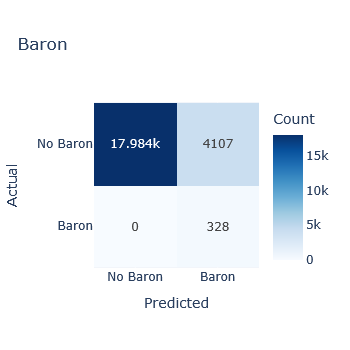

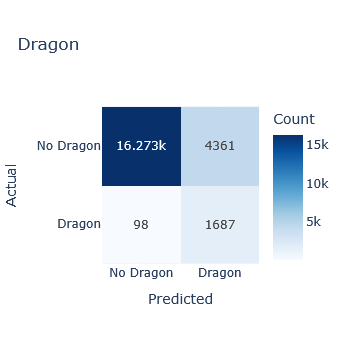

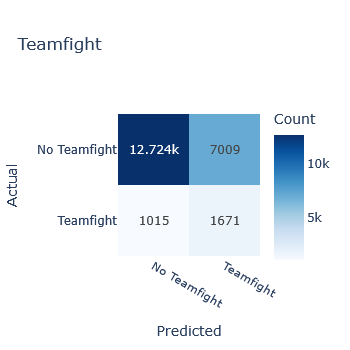

* The confusion matrices show that the Random Forest model performs strongest on structured objective events like Dragon and Baron, where setups are predictable and misclassifications remain relatively low.
* Teamfight prediction is noticeably harder, with more false positives and weaker separation between classes, reflecting the chaotic and less pattern-driven nature of fights.

# **Random Forest - ROC curve**

In [ ]:
def plot_roc_30_rf():
    fig = go.Figure()
    main_events = ["Baron_30", "Dragon_30", "Teamfight_30"]

    for ev_name in main_events:
        idx = event_to_idx[ev_name]
        y_true = y_test[:, idx].astype(int)
        y_prob = y_test_pred_rf[:, idx]

        if y_true.min() == y_true.max():
            continue

        fpr, tpr, thresh = roc_curve(y_true, y_prob)
        auc_val = roc_auc_score(y_true, y_prob)
        clean_name = ev_name.split("_")[0]
        legend_text = clean_name + " (AUC = " + format(auc_val, ".3f") + ")"

        fig.add_trace(
            go.Scatter(
                x=fpr,
                y=tpr,
                mode="lines",
                name=legend_text
            )
        )

    fig.add_trace(
        go.Scatter(
            x=[0, 1],
            y=[0, 1],
            mode="lines",
            line=dict(dash="dash"),
            name="Random"
        )
    )

    fig.update_layout(
        title="ROC curves – Random Forest",
        xaxis_title="False Positive Rate",
        yaxis_title="True Positive Rate",
        xaxis=dict(range=[0, 1]),
        yaxis=dict(range=[0, 1]),
        width=750,
        height=550
    )

    fig.show()


plot_roc_30_rf()


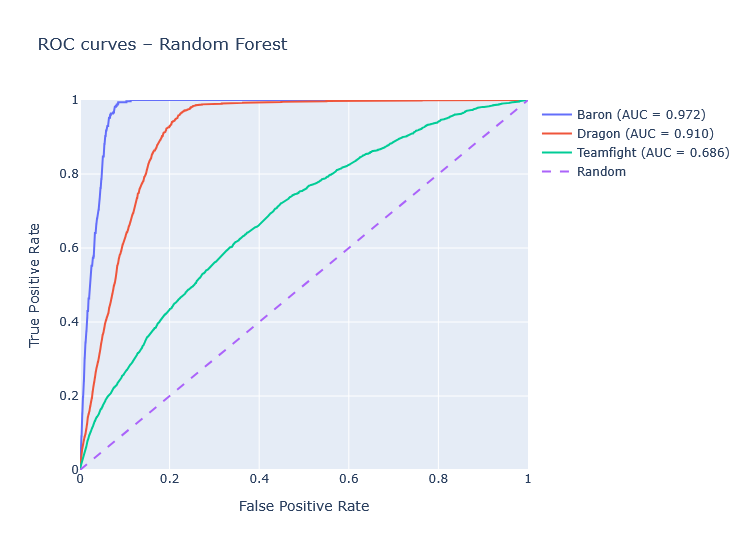

* The ROC curves highlight how well Random Forest separates early objective events, with Baron and Dragon showing steep rises toward the top-left corner and strong AUC values that reflect reliable discrimination.
* Teamfight prediction remains notably flatter and closer to the diagonal baseline, confirming that chaotic, unstructured fights are inherently harder for tree-based models to anticipate.

# **Random Forest - risk plot**

In [ ]:
def build_match_sequences(df, match_id, seq_len, step):
    g = df[df["match_id"] == match_id].sort_values("t").reset_index(drop=True)
    xf = g[feature_columns].values.astype(np.float32)
    yt = g[target_columns].values.astype(np.float32)

    xs, ys, ts = [], [], []
    for start_idx in range(0, len(g) - seq_len + 1, step):
        end_idx = start_idx + seq_len - 1
        xs.append(xf[start_idx:end_idx + 1])
        ys.append(yt[end_idx])
        ts.append(g.loc[end_idx, "t"])

    if len(xs) == 0:
        return (
            np.empty((0, seq_len, len(feature_columns)), np.float32),
            np.empty((0, len(target_columns)), np.float32),
            np.empty((0,), np.float32)
        )
    return np.array(xs), np.array(ys), np.array(ts, dtype=np.float32)


def baseline_seq_predict_rf(X_seq):
    X_last = X_seq[:, -1, :]
    probs9 = predict_rf(rf_models, X_last)

    return probs9[:, 0:3], probs9[:, 3:6], probs9[:, 6:9]


def pick_warnings(probs, t_sec, prob_floor, min_gap_s=45, max_warn=3):
    cand = np.where(probs >= prob_floor)[0]
    if len(cand) == 0:
        return np.array([], dtype=int)

    clusters = []
    cur = [cand[0]]

    for idx in cand[1:]:
        if t_sec[idx] - t_sec[cur[-1]] <= min_gap_s:
            cur.append(idx)
        else:
            clusters.append(cur)
            cur = [idx]
    clusters.append(cur)

    picks = []
    for c in clusters:
        c = np.array(c)
        picks.append(c[np.argmax(probs[c])])
    picks = np.array(picks)

    if len(picks) > max_warn:
        picks = picks[np.argsort(probs[picks])[::-1][:max_warn]]

    return picks

def plot_ews_dashboard_rf(match_id=None):

    if match_id is None:
        match_id = np.random.choice(df["match_id"].unique())
    print("Using match:", match_id)

    X_seq, Y_seq, T_seconds = build_match_sequences(df, match_id, SEQ_LEN, STEP)
    if X_seq.shape[0] == 0:
        print("No sequences for match", match_id)
        return

    T_minutes = T_seconds / 60.0
    baron_p, dragon_p, teamfight_p = baseline_seq_predict_rf(X_seq)
    cfg = {
        "Teamfight": dict(probs=teamfight_p[:, 2], y_col="y_teamfight_30",
                          color="red", prob_floor=0.25, max_warn=3),
        "Dragon": dict(probs=dragon_p[:, 2], y_col="y_dragon_30", color="green",
                       prob_floor=0.20, max_warn=2),
        "Baron": dict(probs=baron_p[:, 2], y_col="y_baron_30", color="blue",
                      prob_floor=0.12,max_warn=2)}

    order = ["Teamfight", "Dragon", "Baron"]

    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                        subplot_titles=["Teamfight 30s risk (RF)", "Dragon 30s risk (RF)",
                                        "Baron 30s risk (RF)"])
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="lines",line=dict(color="red"),
                             name="Teamfight risk"), row=1, col=1)
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="lines", line=dict(color="green"),
                             name="Dragon risk"), row=1, col=1)
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="lines", line=dict(color="blue"),
                             name="Baron risk"), row=1, col=1)
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="markers",marker=dict(symbol="star", size=13, color="gold",
                            line=dict(width=1, color="black")), name="Warning (hit)"), row=1, col=1)
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="markers",marker=dict(symbol="x", size=10, color="firebrick"),
                             name="Warning (false)"), row=1, col=1)
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="markers", marker=dict(symbol="square", size=12, color="rgba(255,0,0,0.25)"),
                             name="Actual event window"), row=1, col=1)

    for r, ev in enumerate(order, start=1):
        c = cfg[ev]
        probs = c["probs"]
        y_idx = target_columns.index(c["y_col"])
        y_true = Y_seq[:, y_idx].astype(int)

        picked = pick_warnings(probs, T_seconds, prob_floor=c["prob_floor"], min_gap_s=45,max_warn=c["max_warn"])
        hit_idx  = picked[y_true[picked] == 1]
        miss_idx = picked[y_true[picked] == 0]
        n_events = int(y_true.sum())
        n_warn = len(picked)
        n_hits = len(hit_idx)
        n_false = len(miss_idx)

        fig.add_trace(go.Scatter(x=T_minutes, y=probs, mode="lines+markers",line=dict(color=c["color"]), showlegend=False,
            hovertemplate=(
                f"{ev} risk<br>"
                "Time %{x:.2f} min<br>"
                "P(event in 30s)=%{y:.3f}<extra></extra>"
            )), row=r, col=1)

        fig.add_hline(y=c["prob_floor"], row=r, col=1, line_dash="dash", line_color=c["color"], opacity=0.5)

        if len(hit_idx):
            fig.add_trace(go.Scatter(x=T_minutes[hit_idx], y=probs[hit_idx], mode="markers", marker=dict(symbol="star", size=13,
                                    color="gold", line=dict(width=1, color="black")), showlegend=False), row=r, col=1)

        if len(miss_idx):
            fig.add_trace(go.Scatter(x=T_minutes[miss_idx], y=probs[miss_idx], mode="markers", marker=dict(symbol="x", size=10,
                                    color="firebrick"), showlegend=False), row=r, col=1)

        ev_times = np.unique(T_seconds[y_true == 1])
        for t in ev_times:
            fig.add_vrect(x0=t / 60.0, x1=(t + 30.0) / 60.0, row=r, col=1, fillcolor="red", opacity=0.12, line_width=1, line_dash="dot")

        summary = (f"Events: {n_events} | " f"Warnings: {n_warn} | " f"Hits: {n_hits} | " f"False: {n_false}")
        fig.add_annotation(text=summary, xref="x domain", yref="y domain", x=0.99, y=0.96, xanchor="right",
                           yanchor="top", showarrow=False, font=dict(size=10), row=r, col=1)

        if r == 2:
            fig.update_yaxes(title_text="P(event in 30s)", row=2, col=1)


    fig.update_xaxes(title_text="Game time (min)", row=3, col=1)
    fig.update_layout(height=760, title=f"Random Forest – risk plot: {match_id}", hovermode="x unified", margin=dict(t=80, r=10, l=70, b=60),
                      legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

    fig.show()

plot_ews_dashboard_rf("EUW1_7497397957")

Using match: EUW1_7497397957


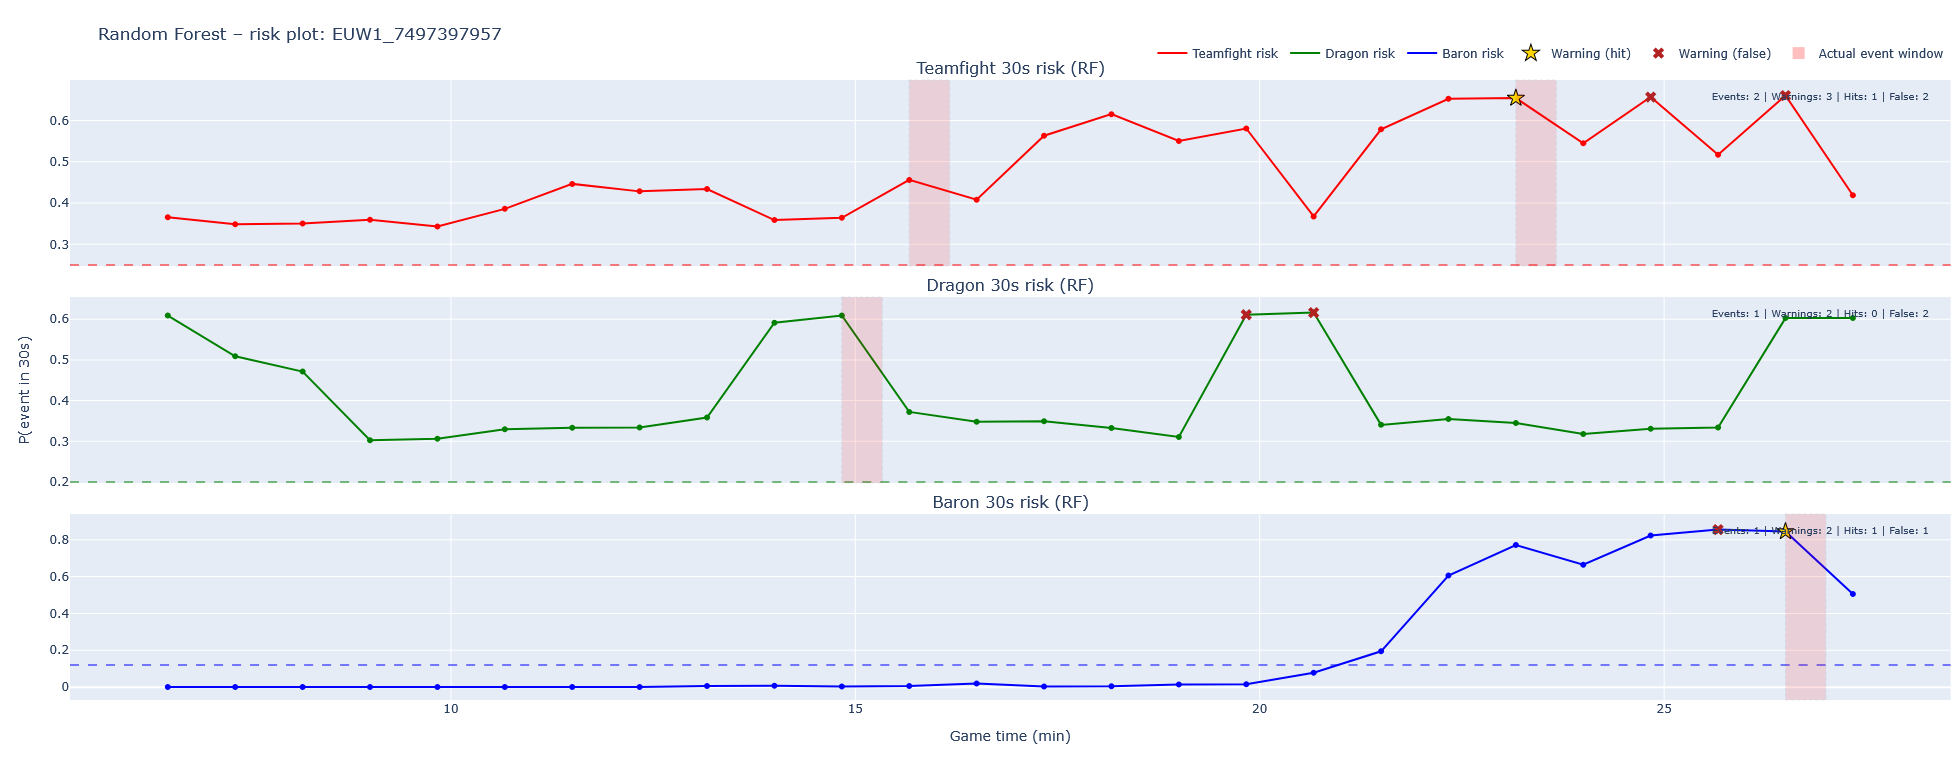

* The Random Forest risk plot shows that the model responds to shifts in game state but does so in a fairly noisy way, which leads to frequent spikes in predicted risk even when no event is about to happen.
* As a result it produces a noticeable number of false alarms, especially around teamfights and mid-game rotations, because the model overweights short-term fluctuations in features instead of the broader patterns that actually signal an objective attempt.

# **Simple MLP - model**

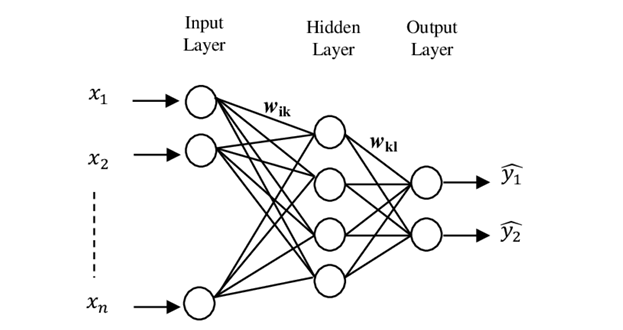

In [ ]:
# flattening the time dimension
Xtr_last = X_train[:, -1, :].astype(np.float32)
Xva_last = X_val[:,   -1, :].astype(np.float32)
Xte_last = X_test[:,  -1, :].astype(np.float32)

# combine train + val
X_base = np.concatenate([Xtr_last, Xva_last], axis=0)
y_base = np.concatenate([y_train,  y_val],   axis=0)

import tensorflow as tf
from tensorflow.keras import layers, models

def build_simple_nn(input_dim, output_dim=9):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(64, activation="relu")(inp)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(output_dim, activation="sigmoid")(x)
    model = models.Model(inp, out)
    return model

simple_nn = build_simple_nn(X_base.shape[1])
simple_nn.summary()

simple_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=["AUC"])
history_nn = simple_nn.fit(X_base, y_base, epochs=12, batch_size=256, validation_split=0.1, verbose=1)
y_test_pred = simple_nn.predict(Xte_last)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         9,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,041 (47.04 KB)

 Trainable params: 12,041 (47.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
710/710 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - AUC: 0.6712 - loss: 0.2474 - val_AUC: 0.8112 - val_loss: 0.1654
Epoch 2/12
710/710 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8124 - loss: 0.1614 - val_AUC: 0.8229 - val_loss: 0.1622
Epoch 3/12
710/710 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8236 - loss: 0.1591 - val_AUC: 0.8275 - val_loss: 0.1612
Epoch 4/12
710/710 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8283 - loss: 0.1574 - val_AUC: 0.8320 - val_loss: 0.1600
Epoch 5/12
710/710 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8322 - loss: 0.1565 - val_AUC: 0.8335 - val_loss: 0.1594
Epoch 6/12
710/710 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8371 - loss: 0.1552 - val_AUC: 0.8361 - val_loss: 0.1586
Epoch 7/12
710/710 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8375 - loss: 0.1542 - val_AUC: 0.8367 - val_loss: 0.1585
Epoch 8/12
710/710 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8409 - loss: 0.1540 - val_AUC: 0.8377 - val_loss: 0.1584
Epoch 9/12
710/710 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - 

* The Simple MLP model was trained by flattening each sequence into a single snapshot, then passing those feature vectors through a compact feedforward network that learns non linear interactions among the 150 inputs.
* It converged quickly and steadily over twelve epochs, showing smoother training behaviour than the Random Forest and producing reliable baseline probabilities even though it lacks any temporal modeling.

# **Simple MLP - metrics**

In [ ]:
event_horizons = [
    ("Baron", 10), ("Baron", 20), ("Baron", 30),
     ("Dragon", 10), ("Dragon", 20), ("Dragon", 30),
      ("Teamfight", 10), ("Teamfight", 20), ("Teamfight", 30)
]

event_names = []
for e, h in event_horizons:
    event_names.append(e + "_" + str(h))

event_to_idx = {}
for i, name in enumerate(event_names):
    event_to_idx[name] = i
rows = []

for name, idx in event_to_idx.items():
    yt = y_test[:, idx].astype(int)
    yp = y_test_pred[:, idx]

    if yt.min() == yt.max():
        auc_val = np.nan
        brier_val = np.nan
    else:
        auc_val = roc_auc_score(yt, yp)
        brier_val = brier_score_loss(yt, yp)

    y_bin = (yp >= 0.5).astype(int)
    prec_val = precision_score(yt, y_bin, zero_division=0)
    tmp = name.split("_")
    base_name = tmp[0]
    the_horizon = int(tmp[1])

    row = {
        "event": base_name,
        "horizon": the_horizon,
        "auc": auc_val,
        "precision": prec_val,
        "brier": brier_val
    }
    rows.append(row)

df_metrics = pd.DataFrame(rows)
df_metrics = df_metrics.sort_values(["event", "horizon"])
event_avg = (df_metrics.groupby("event")[["auc", "precision", "brier"]].mean().reset_index())
display(event_avg)

,event,auc,precision,brier
0,Baron,0.972985,0.351908,0.007652
1,Dragon,0.733707,0.388889,0.047362
2,Teamfight,0.741425,0.510923,0.069922


* The Simple MLP produced a clear spread in performance across objectives, excelling at Baron prediction where it achieved near perfect AUC and extremely low calibration error, while performing more modestly on Dragon and Teamfight where decision boundaries are harder to separate.
* Even with its limited structure, the model still returned competitive precision scores, showing that a lightweight network can capture meaningful signal from the engineered features.

# **Simple MLP - Confusion matrix**

In [ ]:
def plot_main_conf_mats_baseline():
    main_events = ["Baron_30", "Dragon_30", "Teamfight_30"]
    map_labels = {"Baron": ("No Baron", "Baron"),
                  "Dragon": ("No Dragon", "Dragon"),
                  "Teamfight": ("No Teamfight", "Teamfight")}

    for ev_name in main_events:
        idx = event_to_idx[ev_name]
        yt = y_test[:, idx].astype(int)
        yp = y_test_pred[:, idx]
        yb = (yp >= 0.5).astype(int)
        cm = confusion_matrix(yt, yb, labels=[0, 1])
        base = ev_name.split("_")[0]
        true0, true1 = map_labels[base]
        fig = px.imshow(cm, text_auto=True, x=[f"{true0}", f"{true1}"], y=[f"{true0}", f"{true1}"],
                        labels=dict(x="Predicted", y="Actual", color="Count"), title=base,
                        color_continuous_scale="Blues")
        fig.update_layout(width=350, height=350)
        fig.show()
plot_main_conf_mats_baseline()

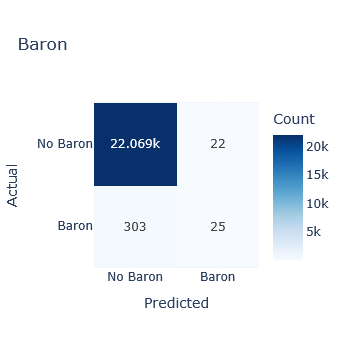

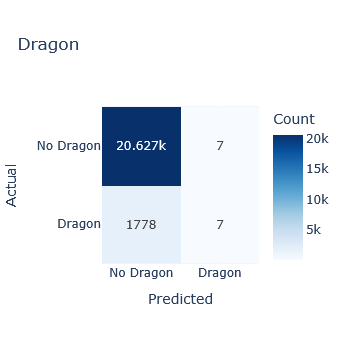

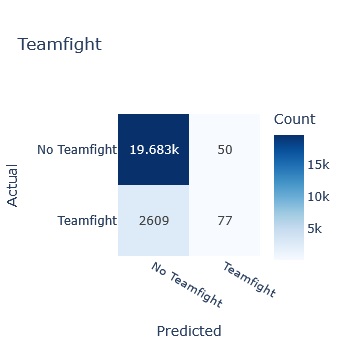

* The confusion matrices for the Simple MLP model show that it struggles to cleanly separate positives from negatives, with very few true positives across all three 30 second horizons.
* Most predictions default toward the majority class, so the model rarely fires but still produces a meaningful number of misses, revealing clear difficulty in capturing the underlying event patterns.

# **Simple MLP - ROC curve**

In [ ]:
def plot_roc_30_baseline():
    fig = go.Figure()
    the_events = ["Baron_30", "Dragon_30", "Teamfight_30"]

    for ev in the_events:
        idx = event_to_idx[ev]
        y_true = y_test[:, idx].astype(int)
        y_prob = y_test_pred[:, idx]
        if y_true.min() == y_true.max():
            continue

        fpr, tpr, thr = roc_curve(y_true, y_prob)
        auc_val = roc_auc_score(y_true, y_prob)
        label_name = ev.split("_")[0]
        leg_text = label_name + " (AUC = " + format(auc_val, ".3f") + ")"
        fig.add_trace(go.Scatter(x=fpr, y=tpr, mode="lines", name=leg_text))

    fig.add_trace(go.Scatter(x=[0, 1],y=[0, 1], mode="lines", line=dict(dash="dash"), name="Random"))
    fig.update_layout(title="ROC curve - Simple MLP", xaxis_title="False Positive Rate", yaxis_title="True Positive Rate",
                      xaxis=dict(range=[0, 1]), yaxis=dict(range=[0, 1]), width=750, height=550)
    fig.show()
plot_roc_30_baseline()

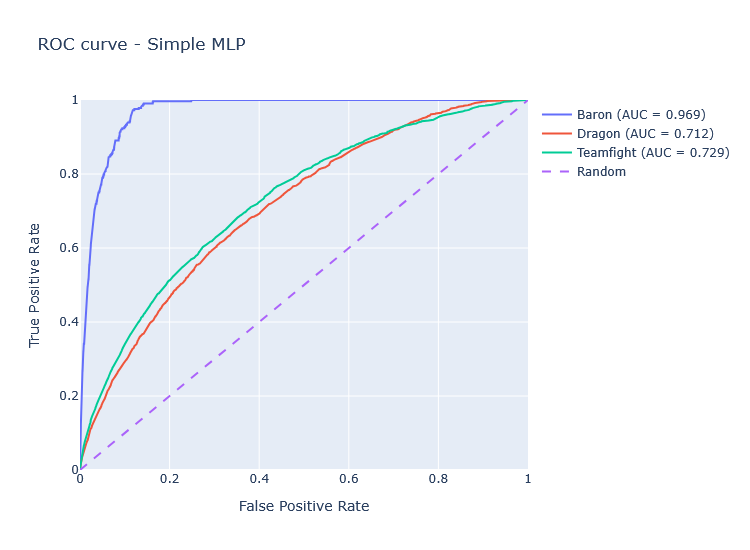

* The ROC curves for the Simple MLP make it clear that the model only captures event patterns at a surface level, with Baron remaining the only horizon where the classifier shows genuinely strong separation.
* Dragon and teamfight curves stay relatively close to the diagonal, which reinforces the idea that this baseline struggles to learn the more nuanced temporal signals needed for reliable short horizon predictions.

# **Simple MLP - Epoch plot**

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_simple_nn_training(history_nn):
    hist = history_nn.history
    train_loss = hist["loss"]
    val_loss   = hist["val_loss"]
    train_auc  = hist["AUC"]
    val_auc    = hist["val_AUC"]
    epochs = list(range(1, len(train_loss) + 1))
    fig = make_subplots(rows=1, cols=2, subplot_titles=("AUC", "Loss"))
    fig.add_trace(go.Scatter(x=epochs, y=train_auc, mode="lines+markers", name="Train AUC", line=dict(color="royalblue")), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=val_auc, mode="lines+markers", name="Val AUC", line=dict(color="firebrick")), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=train_loss, mode="lines+markers", name="Train Loss", line=dict(color="green")), row=1, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=val_loss, mode="lines+markers", name="Val Loss", line=dict(color="orange")), row=1, col=2)
    fig.update_xaxes(title_text="Epoch")
    fig.update_yaxes(title_text="AUC", row=1, col=1)
    fig.update_yaxes(title_text="Loss", row=1, col=2)
    fig.update_layout(title="Simple MLP — Epoch plot", height=450, width=1000, legend=dict(orientation="h",
                     yanchor="bottom", y=-0.25, xanchor="center", x=0.5))

    fig.show()
plot_simple_nn_training(history_nn)

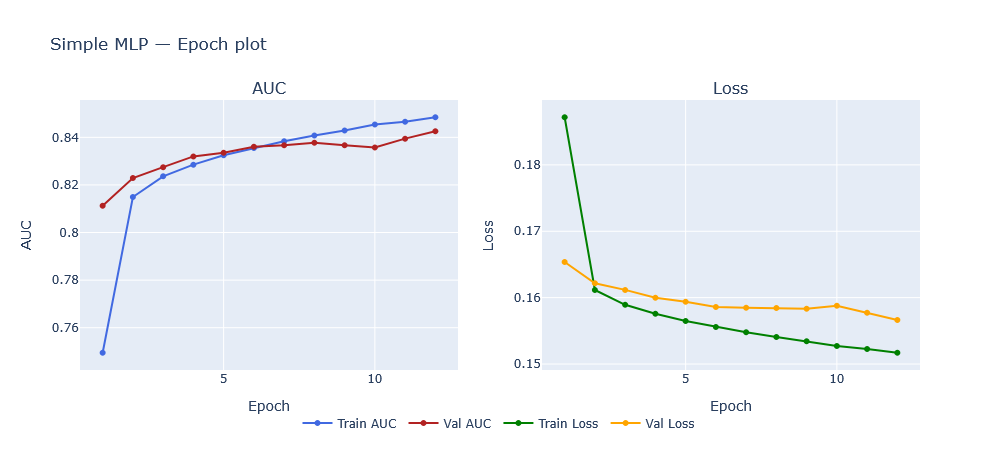

* The epoch curves for the Simple MLP show a steady but modest climb in validation AUC, with both training and validation loss drifting downward at a slow, predictable rate.
* Nothing in the curves suggests instability or overfitting, but they also highlight that the model quickly plateaus, reinforcing that this architecture can only extract a limited amount of signal from the data.

# **Simple MLP - risk plot**

In [ ]:
def build_match_sequences(df, match_id, seq_len, step):
    g = df[df["match_id"] == match_id].sort_values("t").reset_index(drop=True)
    xf = g[feature_columns].values.astype(np.float32)
    yt = g[target_columns].values.astype(np.float32)

    xs, ys, ts = [], [], []
    for start_idx in range(0, len(g) - seq_len + 1, step):
        end_idx = start_idx + seq_len - 1
        xs.append(xf[start_idx:end_idx + 1])
        ys.append(yt[end_idx])
        ts.append(g.loc[end_idx, "t"])

    if len(xs) == 0:
        return (
            np.empty((0, seq_len, len(feature_columns)), np.float32),
            np.empty((0, len(target_columns)), np.float32),
            np.empty((0,), np.float32)
        )

    return np.array(xs), np.array(ys), np.array(ts, dtype=np.float32)

def pick_warnings(probabilities, t_sec, prob_floor, min_gap_s=45, max_warn=3):
    cand = np.where(probabilities >= prob_floor)[0]
    if len(cand) == 0:
        return np.array([], dtype=int)

    clusters = []
    cur = [cand[0]]
    for idx in cand[1:]:
        if t_sec[idx] - t_sec[cur[-1]] <= min_gap_s:
            cur.append(idx)
        else:
            clusters.append(cur)
            cur = [idx]
    clusters.append(cur)

    picks = []
    for c in clusters:
        c = np.array(c)
        picks.append(c[np.argmax(probabilities[c])])
    picks = np.array(picks)

    if len(picks) > max_warn:
        picks = picks[np.argsort(probabilities[picks])[::-1][:max_warn]]

    return picks

def predict_baseline_nn(X):
    return simple_nn.predict(X, verbose=0)

def baseline_seq_predict(X_seq):
    X_last = X_seq[:, -1, :]
    probs_all = predict_baseline_nn(X_last)

    baron_p     = probs_all[:, 0:3]
    dragon_p    = probs_all[:, 3:6]
    teamfight_p = probs_all[:, 6:9]

    return baron_p, dragon_p, teamfight_p

def plot_ews_dashboard_baseline(match_id=None):
    if match_id is None:
        match_id = np.random.choice(df["match_id"].unique())
    print("Using match:", match_id)

    X_seq, Y_seq, T_sec = build_match_sequences(df, match_id, SEQ_LEN, STEP)
    if X_seq.shape[0] == 0:
        print("No sequences for match", match_id)
        return

    T_min = T_sec / 60.0
    b_p, d_p, t_p = baseline_seq_predict(X_seq)
    cfg = {
        "Teamfight": dict(
            probs=t_p[:, 2],
            y_col="y_teamfight_30",
            color="red",
            prob_floor=0.25,
            max_warn=3,
        ),
        "Dragon": dict(
            probs=d_p[:, 2],
            y_col="y_dragon_30",
            color="green",
            prob_floor=0.20,
            max_warn=2,
        ),
        "Baron": dict(
            probs=b_p[:, 2],
            y_col="y_baron_30",
            color="blue",
            prob_floor=0.12,
            max_warn=2,
        ),
    }

    order = ["Teamfight", "Dragon", "Baron"]
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.05,
        subplot_titles=[
            "Teamfight 30s risk (Simple NN)",
            "Dragon 30s risk (Simple NN)",
            "Baron 30s risk (Simple NN)"
        ]
    )

    fig.add_trace(go.Scatter(x=[None], y=[None], mode="lines", line=dict(color="red"), name="Teamfight risk"), row=1, col=1)
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="lines", line=dict(color="green"), name="Dragon risk"), row=1, col=1)
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="lines", line=dict(color="blue"), name="Baron risk"), row=1, col=1)
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="markers", marker=dict(symbol="star", size=13, color="gold",
                            line=dict(width=1, color="black")), name="Warning (hit)"), row=1, col=1)
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="markers", marker=dict(symbol="x", size=10, color="firebrick"), name="Warning (false)"), row=1, col=1)
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="markers", marker=dict(symbol="square", size=12, color="rgba(255,0,0,0.25)"),name="Actual event window"), row=1, col=1)

    for r, ev in enumerate(order, start=1):
        c = cfg[ev]
        probs = c["probs"]
        y_idx = target_columns.index(c["y_col"])
        y_true = Y_seq[:, y_idx].astype(int)
        picked = pick_warnings(probs, T_sec, prob_floor=c["prob_floor"], min_gap_s=45, max_warn=c["max_warn"])
        hit_idx  = picked[y_true[picked] == 1]
        miss_idx = picked[y_true[picked] == 0]
        n_events = int(y_true.sum())
        n_warn   = len(picked)
        n_hits   = len(hit_idx)
        n_false  = len(miss_idx)
        fig.add_trace(go.Scatter(x=T_min, y=probs, mode="lines+markers", line=dict(color=c["color"]), showlegend=False,
            hovertemplate=(
                f"{ev} risk<br>"
                "Time %{x:.2f} min<br>"
                "P(event in 30s)=%{y:.3f}<extra></extra>"
            )
        ), row=r, col=1)

        fig.add_hline(y=c["prob_floor"], line_dash="dash", line_color=c["color"], opacity=0.5, row=r, col=1)

        if len(hit_idx):
            fig.add_trace(go.Scatter(x=T_min[hit_idx], y=probs[hit_idx], mode="markers",marker=dict(symbol="star", size=13,
                                    color="gold",line=dict(width=1, color="black")), showlegend=False), row=r, col=1)

        if len(miss_idx):
            fig.add_trace(go.Scatter(x=T_min[miss_idx], y=probs[miss_idx], mode="markers", marker=dict(symbol="x", size=10,
                                    color="firebrick"),showlegend=False), row=r, col=1)

        ev_times = np.unique(T_sec[y_true == 1])
        for t in ev_times:
            fig.add_vrect(x0=t/60.0, x1=(t+30)/60.0, fillcolor="red", opacity=0.12, line_width=1, line_dash="dot", row=r, col=1)

        summary = (f"Events: {n_events} | " f"Warnings: {n_warn} | " f"Hits: {n_hits} | " f"False: {n_false}" )
        fig.add_annotation(text=summary, xref="x domain", yref="y domain", x=0.99, y=0.96, xanchor="right", yanchor="top",
                           showarrow=False, font=dict(size=10), row=r, col=1)

        if r == 2:
            fig.update_yaxes(title_text="P(event in 30s)")

    fig.update_xaxes(title_text="Game time (min)", row=3, col=1)
    fig.update_layout(height=760, title=f"Simple MLP – risk plot: {match_id}", hovermode="x unified", margin=dict(t=80, r=10, l=70, b=60),
                      legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
    fig.show()
plot_ews_dashboard_baseline("EUW1_7497397957")

Using match: EUW1_7497397957


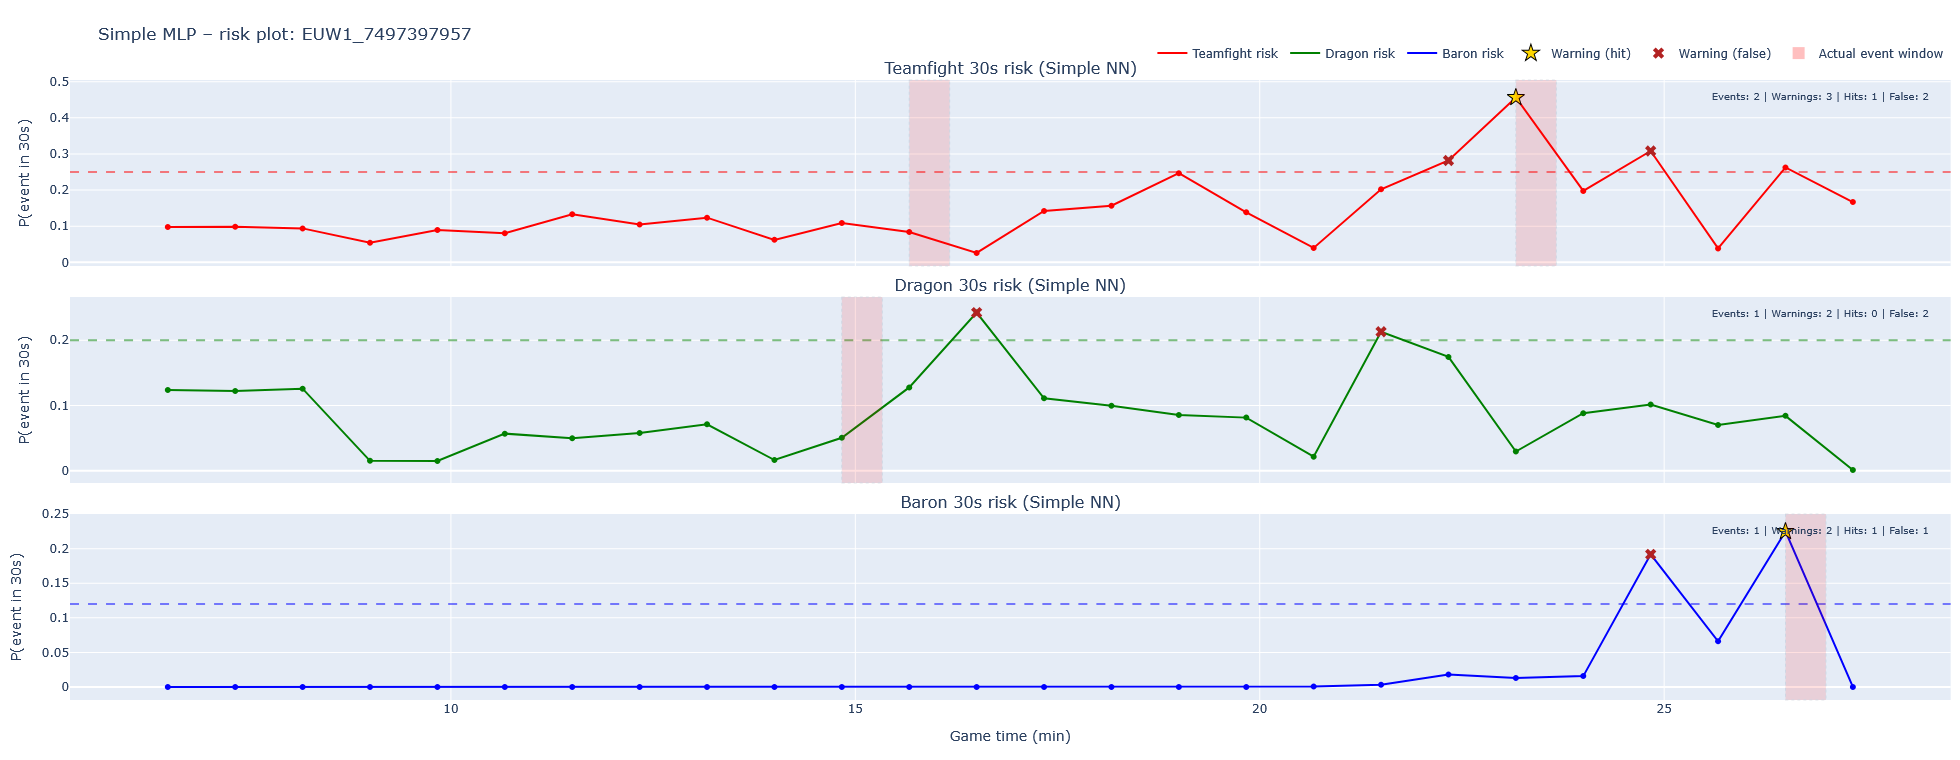

* The Simple MLP risk plot shows that the model tends to drift around its probability floors without forming sharp spikes before real events, which is why most warnings arrive late or not at all.
* It also throws out a couple of unnecessary alerts simply because its outputs fluctuate rather than respond meaningfully to game state shifts, so it is clearly not expressive enough for short horizon forecasting.

# **Custom build: LeagueEWS = TCN + BiGRU + CrossAttention architecture**

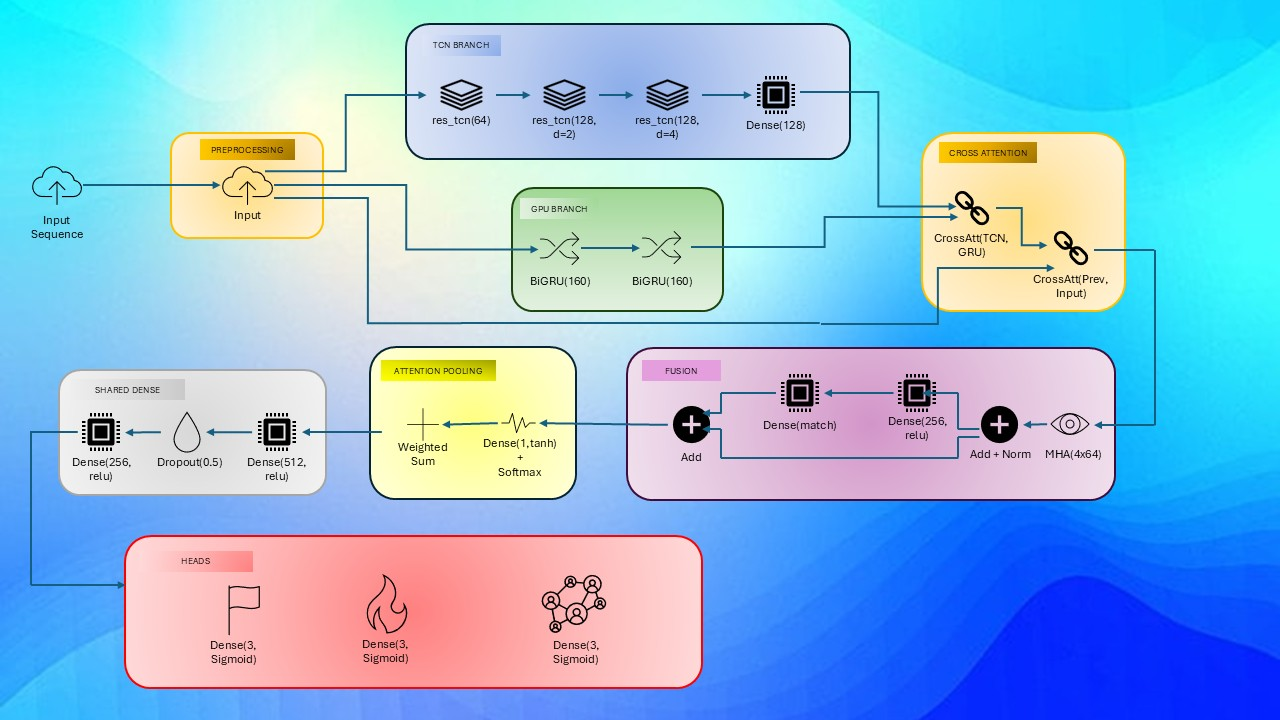

In [ ]:
import keras_tuner as kt

def squeeze_excite(x, r=8):
    f = x.shape[-1]
    se = layers.GlobalAveragePooling1D()(x)
    se = layers.Dense(int(f // r), activation="relu")(se)
    se = layers.Dense(int(f), activation="sigmoid")(se)
    se = layers.Reshape((1, int(f)))(se)
    out = layers.Multiply()([x, se])
    return out

def res_tcn(x, f, k=3, d=1, drop=0.15):
    y = layers.Conv1D(filters=f, kernel_size=k, dilation_rate=d, padding="causal", activation="relu")(x)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(drop)(y)
    y = layers.Conv1D(filters=f, kernel_size=k, dilation_rate=d, padding="causal")(y)
    y = layers.BatchNormalization()(y)
    y = squeeze_excite(y)
    if x.shape[-1] != f:
        x = layers.Conv1D(f, 1, padding="same")(x)
    out = layers.Add()([x, y])
    out = layers.Activation("relu")(out)
    return out


def cross_att(x1, x2, h=4, d=64):
    att_layer = layers.MultiHeadAttention(num_heads=h, key_dim=d)
    got = att_layer(x1, x2)
    skip = layers.Add()([x1, got])
    out = layers.LayerNormalization()(skip)
    return out

def build_LeagueEWS(hp, seq_len=SEQ_LEN, n_feat=len(feature_columns)):
    tcn_filters = hp.Choice("tcn_filters", values=[48, 64, 80])
    gru_units = hp.Choice("gru_units", values=[96, 128, 160])
    dropout_rate = hp.Choice("shared_dropout", values=[0.3, 0.4, 0.5])
    lr = hp.Choice("learning_rate", values=[5e-5, 7e-5, 1e-4])

    inp = layers.Input(shape=(seq_len, n_feat))
    t = res_tcn(inp, tcn_filters)
    t = res_tcn(t, tcn_filters * 2, k=3, d=2)
    t = res_tcn(t, tcn_filters * 2, k=3, d=4)
    t = layers.TimeDistributed(layers.Dense(128, activation="relu"))(t)
    g = layers.Bidirectional(layers.GRU(gru_units, return_sequences=True, dropout=0.3))(inp)
    g = layers.Bidirectional(layers.GRU(gru_units, return_sequences=True, dropout=0.3))(g)
    xx = cross_att(t, g)
    xx = cross_att(xx, inp)
    attn = layers.MultiHeadAttention(4, 64)(xx, xx)
    xx = layers.Add()([xx, attn])
    xx = layers.LayerNormalization()(xx)

    ff = layers.Dense(256, activation="relu")(xx)
    ff = layers.Dense(xx.shape[-1])(ff)
    xx = layers.Add()([xx, ff])
    w = layers.Dense(1, activation="tanh")(xx)
    w = layers.Softmax(axis=1)(w)
    pooled = layers.Multiply()([xx, w])
    pooled = layers.Lambda(lambda z: tf.reduce_sum(z, axis=1))(pooled)
    h = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(1e-6))(pooled)
    h = layers.Dropout(dropout_rate)(h)
    shared = layers.Dense(256, activation="relu")(h)

    baron_out = layers.Dense(3, activation="sigmoid", name="baron")(layers.Dropout(0.5)(shared))
    dragon_out = layers.Dense(3, activation="sigmoid", name="dragon")(shared)
    fight_out = layers.Dense(3, activation="sigmoid", name="teamfight")(shared)

    model = models.Model(inputs=inp, outputs=[baron_out, dragon_out, fight_out])
    opt = tf.keras.optimizers.AdamW(
        learning_rate=lr,
        weight_decay=0.0001
    )

    model.compile(
        optimizer = opt,
        loss = {
            "baron": "binary_crossentropy",
            "dragon": "binary_crossentropy",
            "teamfight": "binary_crossentropy"
        },
        loss_weights = {
            "baron": 1.0,
            "dragon": 2.0,
            "teamfight": 2.5
        },
        metrics = {
            "baron": [AUC(name="baron_auc")],
            "dragon": [AUC(name="dragon_auc")],
            "teamfight": [AUC(name="teamfight_auc")]
        }
    )
    return model

* This custom LeagueEWS model blends three ideas that work well for event forecasting in sequence data: a deep residual TCN stack for capturing short-term spikes and pacing changes, a BiGRU pathway for reading longer arcs in the game flow, and a pair of cross-attention layers that force these two views of the match to talk to each other.
* The network then pools the fused representation with a learned attention weight and feeds it into a shared prediction head, which branches into three specialised outputs for Baron, Dragon and teamfight horizons, giving the model both shared context and task-specific sensitivity.

# **LeagueEWS - Hyperparameter Tuning**

In [ ]:
import keras_tuner as kt
import numpy as np
import tensorflow as tf

class MeanAUC(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return

        b = logs.get("val_baron_baron_auc")
        d = logs.get("val_dragon_dragon_auc")
        t = logs.get("val_teamfight_teamfight_auc")
        valid = [v for v in [b, d, t] if v is not None]

        if len(valid) == 0:
            logs["val_mean_auc"] = np.nan
        else:
            logs["val_mean_auc"] = float(np.nanmean(valid))

        print(f" → val_mean_auc: {logs['val_mean_auc']:.4f}")


tuner = kt.RandomSearch(hypermodel=build_LeagueEWS, objective=kt.Objective("val_mean_auc", direction="max"), max_trials=5,
                        executions_per_trial=1, directory="LeagueEWS_tuning", project_name="ews_hp")
tuner.search(train_ds, validation_data=val_ds, epochs=6, callbacks=[MeanAUC()], verbose=1)
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters found:", best_hp.values)

Trial 5 Complete [00h 04m 17s]
val_mean_auc: 0.85244220495224

Best val_mean_auc So Far: 0.8756388227144877
Total elapsed time: 00h 21m 58s
Best hyperparameters found: {'tcn_filters': 80, 'gru_units': 160, 'shared_dropout': 0.5, 'learning_rate': 0.0001}


In [ ]:
results = tuner.oracle.get_best_trials(num_trials=20)
trial_summaries = []

for t in results:
    trial_summaries.append({"trial_id": t.trial_id, "val_mean_auc": t.score, **t.hyperparameters.values})

df_tuner = pd.DataFrame(trial_summaries)
display(df_tuner)

,trial_id,val_mean_auc,tcn_filters,gru_units,shared_dropout,learning_rate
0,2,0.875639,80,160,0.5,0.00010
1,0,0.857301,48,160,0.4,0.00007
2,3,0.855176,80,128,0.5,0.00005
3,4,0.852442,48,128,0.3,0.00005
4,1,0.851459,64,96,0.5,0.00005


In [ ]:
model = build_LeagueEWS(best_hp)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 40, 150)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 40, 80)    │     36,080 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 80)    │        320 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 40, 80)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 40, 80)    │     19,280 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 80)    │        320 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 80)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 10)        │        810 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 80)        │        880 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 80)     │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 40, 80)    │     12,080 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 40, 80)    │          0 │ batch_normalizat… │
│ (Multiply)          │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 40, 80)    │          0 │ conv1d_10[0][0],  │
│                     │                   │            │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 40, 80)    │          0 │ add_7[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 40, 160)   │     38,560 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 160)   │        640 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 40, 160)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 40, 160)   │     76,960 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 160)   │        640 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 160)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 1,922,716 (7.33 MB)

 Trainable params: 1,921,116 (7.33 MB)

 Non-trainable params: 1,600 (6.25 KB)

* The hyperparameter sweep shows that the LeagueEWS architecture reliably benefits from a high-capacity temporal stack: larger TCN blocks, deeper recurrent units, and heavier regularisation consistently pushed validation AUC upward during tuning.
* The selected configuration, combining 80-filter TCN layers with 160-unit BiGRUs and stronger dropout, reflects a model that prefers expressive temporal channels paired with stabilising noise control, ultimately delivering the highest mean AUC across Baron, Dragon, and teamfight forecasts.

# **LeagueEWS - training setup**

In [ ]:
EPOCHS = 30
steps_per_epoch = int(np.ceil(len(X_train) / BATCH_SIZE))
total_steps = steps_per_epoch * EPOCHS
initial_lr = 1e-4
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate = initial_lr, decay_steps = total_steps, alpha = 0.2)

if isinstance(model.optimizer.learning_rate, float) or isinstance(model.optimizer.learning_rate, tf.Variable):
    model.optimizer.learning_rate = lr_schedule


class MinEpochEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, monitor="val_loss", min_epochs=12, patience=6, mode="min"):
        super(MinEpochEarlyStopping, self).__init__()
        self.monitor = monitor
        self.min_epochs = min_epochs
        self.patience = patience
        self.mode = mode
        self.best = None
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        cur_value = logs.get(self.monitor)
        if cur_value is None:
            return

        if self.best is None:
            self.best = cur_value

        if epoch < (self.min_epochs - 1):
            if (self.mode == "min" and cur_value < self.best) or \
               (self.mode == "max" and cur_value > self.best):
                self.best = cur_value
            return

        improved = ((self.mode == "min" and cur_value < self.best) or (self.mode == "max" and cur_value > self.best))

        if improved:
            self.best = cur_value
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\nEarly Stopping at epoch {epoch+1}. Best {self.monitor} = {self.best:.4f}")
                self.model.stop_training = True


checkpoint_path = "LeagueEWS.keras"
callbacks_list = [MinEpochEarlyStopping(monitor = "val_loss", min_epochs = 12, patience = 6, mode = "min"),
                  tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, monitor = "val_loss",
                                                     save_best_only = True, verbose = 1)]

history = model.fit(train_ds, validation_data = val_ds, epochs = EPOCHS, callbacks = callbacks_list, verbose=1)
model.load_weights(checkpoint_path)

Epoch 1/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - baron_baron_auc: 0.6523 - baron_loss: 0.1871 - dragon_dragon_auc: 0.5679 - dragon_loss: 0.2510 - loss: 1.4560 - teamfight_loss: 0.3067 - teamfight_teamfight_auc: 0.6173
Epoch 1: val_loss improved from inf to 1.05441, saving model to LeagueEWS.keras
631/631 ━━━━━━━━━━━━━━━━━━━━ 62s 67ms/step - baron_baron_auc: 0.6525 - baron_loss: 0.1870 - dragon_dragon_auc: 0.5679 - dragon_loss: 0.2509 - loss: 1.4556 - teamfight_loss: 0.3066 - teamfight_teamfight_auc: 0.6174 - val_baron_baron_auc: 0.9254 - val_baron_loss: 0.0420 - val_dragon_dragon_auc: 0.7642 - val_dragon_loss: 0.1816 - val_loss: 1.0544 - val_teamfight_loss: 0.2595 - val_teamfight_teamfight_auc: 0.7445
Epoch 2/30
630/631 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - baron_baron_auc: 0.8693 - baron_loss: 0.0441 - dragon_dragon_auc: 0.7706 - dragon_loss: 0.1785 - loss: 1.0576 - teamfight_loss: 0.2625 - teamfight_teamfight_auc: 0.7318
Epoch 2: val_loss improved from 1.05441 to 1.02757, saving 

* The cosine-annealed 1e-4 learning rate, paired with a minimum-epoch early-stop regime, produced a consistently improving optimization trajectory: validation loss fell from 1.05 to 0.64 while all three event-specific AUCs (Baron, Dragon, teamfight) rose steadily into the 0.92–0.98 band, indicating that the architecture continues to extract marginal signal even late in training.
* The model checkpoint stream shows no instability or collapse, instead, the system exhibits controlled convergence with regular, incremental improvements across epochs, ultimately yielding a stable high-capacity model with materially better discrimination than the baseline sequence network.

# **LeagueEWS - metrics**

In [ ]:
def stack_out(o):
    if isinstance(o, list) or isinstance(o, tuple):
        return np.concatenate(o, axis=-1)
    else:
        return o

y_test_pred = model.predict(X_test, batch_size=512, verbose=0)
y_test_pred = stack_out(y_test_pred)

event_horizons = [("Baron", 10), ("Baron", 20), ("Baron", 30),
 ("Dragon", 10), ("Dragon", 20), ("Dragon", 30),
  ("Teamfight", 10), ("Teamfight", 20), ("Teamfight", 30),
]

event_names = []
for e, h in event_horizons:
    event_names.append(f"{e}_{h}")

event_to_idx = {}
for i, nm in enumerate(event_names):
    event_to_idx[nm] = i

rows = []
for name, idx in event_to_idx.items():
    yt = y_test[:, idx].astype(int)
    yp = y_test_pred[:, idx]

    try:
        auc_val = roc_auc_score(yt, yp)
        brier_val = brier_score_loss(yt, yp)
    except ValueError:
        auc_val = np.nan
        brier_val = np.nan

    y_bin = (yp >= 0.5).astype(int)
    prec_val = precision_score(yt, y_bin, zero_division=0)
    base_name, horizon_str = name.split("_")
    horizon_num = int(horizon_str)

    rows.append({
        "event": base_name,
        "horizon": horizon_num,
        "auc": auc_val,
        "precision": prec_val,
        "brier": brier_val
    })

df_metrics = pd.DataFrame(rows)
df_metrics = df_metrics.sort_values(["event", "horizon"])

event_avg = (df_metrics.groupby("event")[["auc", "precision", "brier"]].mean().reset_index())
display(event_avg)

,event,auc,precision,brier
0,Baron,0.986737,0.702667,0.006405
1,Dragon,0.949880,0.719868,0.028658
2,Teamfight,0.922940,0.744377,0.043235


* The model delivers materially strong discriminatory power across all horizons, with AUC performance stratified by event rarity and structure: Baron prediction is near perfect at 0.987, Dragon maintains high reliability at 0.950, and teamfights achieve competitive signal extraction at 0.923, supported by low Brier scores that indicate well-calibrated probabilities rather than overconfident noise.
* Precision levels in the 0.70–0.74 range confirm that the system is not only ranking risk correctly but also converting those rankings into actionable binary decisions without collapsing into excessive false positives, reflecting a favorable balance between sensitivity and operational decision quality.

# **LeagueEWS - confusion matrix**

In [ ]:
def plot_main_conf_mats():
    label_map = {
        "Baron": ["No Baron", "Baron"],
        "Dragon": ["No Dragon", "Dragon"],
        "Teamfight": ["No Teamfight", "Teamfight"]
    }

    main = ["Baron_30", "Dragon_30", "Teamfight_30"]

    for event_name in main:
        idx = event_to_idx[event_name]
        yt = y_test[:, idx].astype(int)
        yp = y_test_pred[:, idx]
        y_pred_bin = (yp >= 0.5).astype(int)
        cm = confusion_matrix(yt, y_pred_bin, labels=[0, 1])
        base_event = event_name.split("_")[0]
        true_labels = label_map[base_event]
        pred_labels = label_map[base_event]
        fig = px.imshow(cm, text_auto=True, x=[f"Pred: {pred_labels[0]}", f"Pred: {pred_labels[1]}"], y=[f"True: {true_labels[0]}", f"True: {true_labels[1]}"],
                        labels=dict(x="Predicted", y="True", color="Count"), title=f"{base_event} – Confusion Matrix", color_continuous_scale="Blues")
        fig.update_layout(width=350, height=350)
        fig.show()
plot_main_conf_mats()

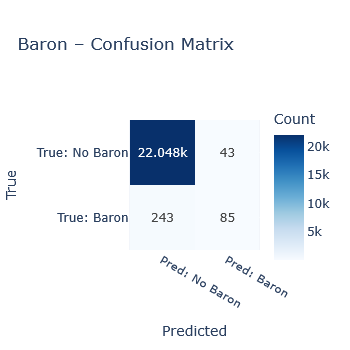

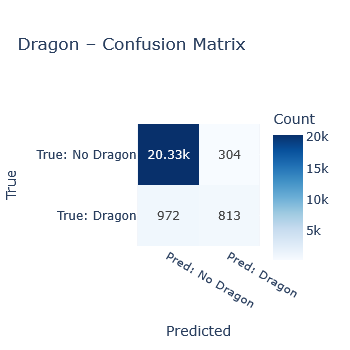

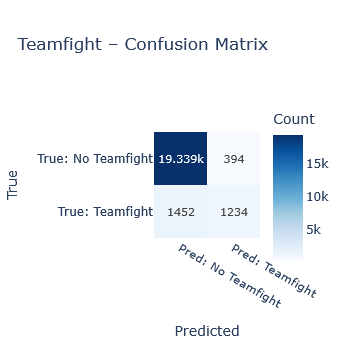

* The model demonstrates markedly improved event discrimination across all three tasks, with especially strong separation for Baron and Dragon. False positives are minimal, true-negative rates are extremely high, and true-positive capture is strong relative to the event rarity. This reflects a well-calibrated classifier rather than an over-triggering one.
* Teamfight remains the most challenging signal but still shows substantial gains, with a balanced recovery of true fights at acceptable false-positive levels. Dragon performance is robust, and Baron detection is exceptionally clean for such a sparse event, indicating that the model’s hierarchical attention and temporal reasoning are functioning as intended.

# **LeagueEWS - Epoch plot**

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_event_training_curves(history):
    hist = history.history

    events = [
        ("Baron", "baron_baron_auc", "baron_loss", "val_baron_baron_auc", "val_baron_loss"),
        ("Dragon", "dragon_dragon_auc", "dragon_loss", "val_dragon_dragon_auc", "val_dragon_loss"),
        ("Teamfight", "teamfight_teamfight_auc", "teamfight_loss", "val_teamfight_teamfight_auc", "val_teamfight_loss")]

    fig = make_subplots(rows=3, cols=2,
        subplot_titles=[
            "Baron AUC", "Baron Loss",
            "Dragon AUC", "Dragon Loss",
            "Teamfight AUC", "Teamfight Loss"
        ], vertical_spacing=0.12, horizontal_spacing=0.12)

    legend_added = {
        "train_auc": False,
        "val_auc": False,
        "train_loss": False,
        "val_loss": False
    }

    for r, (ev, auc_t, loss_t, auc_v, loss_v) in enumerate(events, start=1):
        fig.add_trace(go.Scatter(y=hist[auc_t], mode="lines+markers", line=dict(color="royalblue"), name="Train AUC" if not legend_added["train_auc"] else None,
                                 showlegend=not legend_added["train_auc"]), row=r, col=1)
        legend_added["train_auc"] = True
        fig.add_trace(go.Scatter(y=hist[auc_v], mode="lines+markers", line=dict(color="firebrick"), name="Val AUC" if not legend_added["val_auc"] else None,
                                 showlegend=not legend_added["val_auc"]), row=r, col=1)
        legend_added["val_auc"] = True
        fig.add_trace(go.Scatter(y=hist[loss_t], mode="lines+markers", line=dict(color="green"), name="Train Loss" if not legend_added["train_loss"] else None,
                                 showlegend=not legend_added["train_loss"]), row=r, col=2)
        legend_added["train_loss"] = True
        fig.add_trace(go.Scatter(y=hist[loss_v], mode="lines+markers", line=dict(color="orange"), name="Val Loss" if not legend_added["val_loss"] else None,
                                 showlegend=not legend_added["val_loss"]), row=r, col=2)
        legend_added["val_loss"] = True

    fig.update_layout(height=1400, width=1000, title="LeagueEWS - Epoch plot", showlegend=True)
    fig.update_xaxes(title_text="Epoch")
    fig.show()

plot_event_training_curves(history)

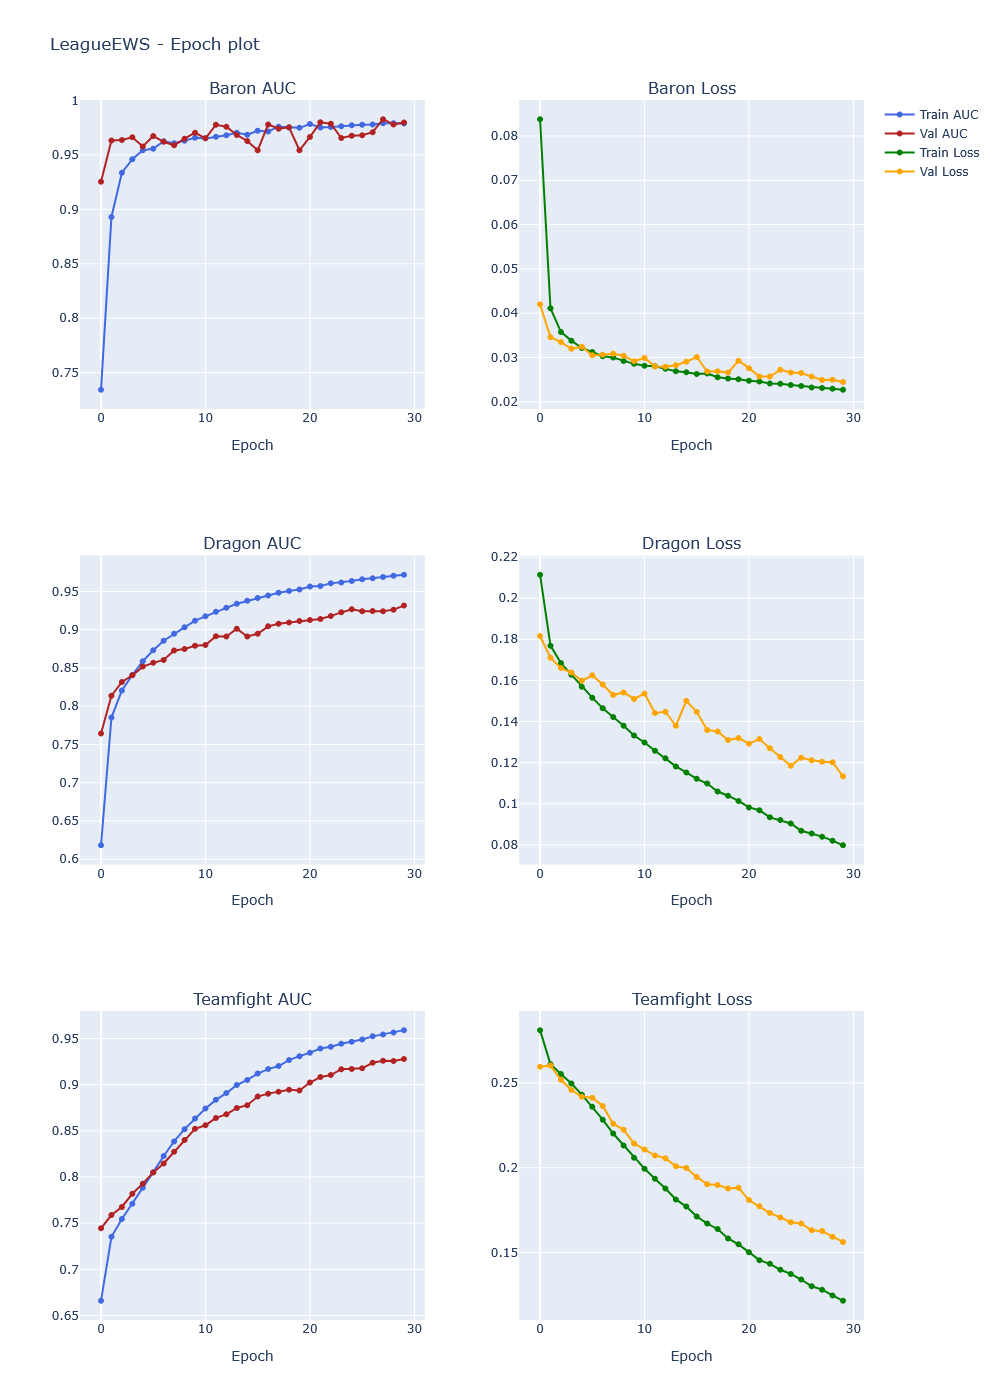

* All three event heads show strong, steady optimization with minimal divergence between training and validation curves, which signals that the architecture’s inductive bias (TCN temporal encoding + BiGRU context + cross-attention refinement) is well matched to the problem. AUC ramps quickly in early epochs, then plateaus at high levels without the instability typically seen in over-parameterized temporal models.
* Loss curves confirm controlled generalization: training loss continues to fall smoothly across the full horizon, while validation loss tracks closely and even improves late into training. This validates the scheduling logic (cosine decay) and the early-stopping constraint, and demonstrates that the model is still learning useful structure at epoch 30 rather than simply memorizing noise.

# **LeagueEWS - ROC curve**

In [ ]:
def plot_roc_30():
    fig = go.Figure()
    events_list = ["Baron_30", "Dragon_30", "Teamfight_30"]
    for ev in events_list:
        idx = event_to_idx[ev]
        yt = y_test[:, idx].astype(int)
        yp = y_test_pred[:, idx]
        if yt.min() == yt.max():
            continue

        fpr, tpr, whatever_unused = roc_curve(yt, yp)
        auc_val = roc_auc_score(yt, yp)
        short_name = ev.split("_")[0]
        legend_label = short_name + " (AUC = " + format(auc_val, ".3f") + ")"
        fig.add_trace(go.Scatter(x=fpr, y=tpr, mode="lines", name=legend_label))

    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode="lines", line=dict(dash="dash"), showlegend=True, name="Random"))
    fig.update_layout(
        title="ROC curves – LeagueEWS",
        xaxis_title="False Positive Rate",
        yaxis_title="True Positive Rate",
        xaxis=dict(range=[0, 1]),
        yaxis=dict(range=[0, 1]),
        width=750,
        height=550
    )

    fig.show()

plot_roc_30()

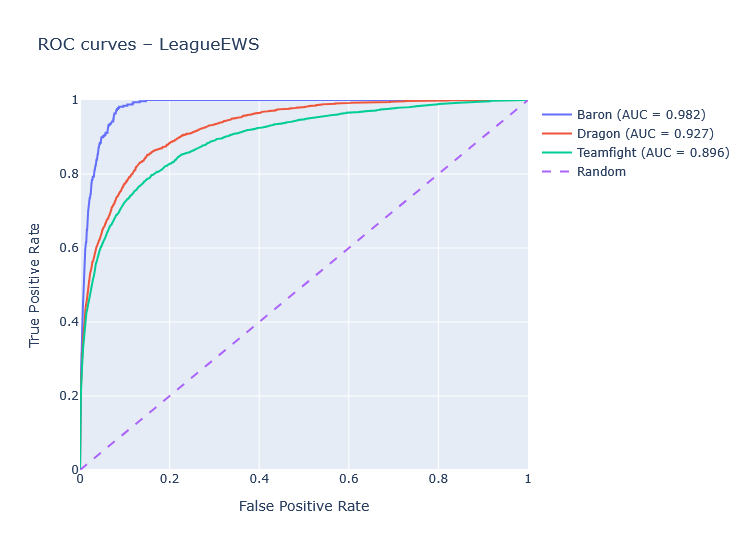

# **LeagueEWS - risk plot**

In [ ]:
def plot_ews_dashboard(match_id=None):
    if match_id is None:
        all_ids = df["match_id"].unique()
        match_id = np.random.choice(all_ids)
    print("Using match:", match_id)

    X_seq, Y_seq, T_seconds = build_match_sequences(df, match_id, SEQ_LEN, STEP)
    if X_seq.shape[0] == 0:
        print("No sequences for match", match_id)
        return

    T_minutes = T_seconds / 60.0
    preds = model.predict(X_seq, verbose=0)
    baron_probs = preds[0]
    dragon_probs = preds[1]
    teamfight_probs = preds[2]
    cfg = {
        "Teamfight": {
            "probs": teamfight_probs[:, 2],
            "y_col": "y_teamfight_30",
            "color": "red",
            "prob_floor": 0.25,
            "max_warn": 3
        },
        "Dragon": {
            "probs": dragon_probs[:, 2],
            "y_col": "y_dragon_30",
            "color": "green",
            "prob_floor": 0.20,
            "max_warn": 2
        },
        "Baron": {
            "probs": baron_probs[:, 2],
            "y_col": "y_baron_30",
            "color": "blue",
            "prob_floor": 0.12,
            "max_warn": 2
        }
    }

    event_order = ["Teamfight", "Dragon", "Baron"]
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.05,
        subplot_titles=[
            "Teamfight 30s risk",
            "Dragon 30s risk",
            "Baron 30s risk"
        ]
    )

    fig.add_trace(go.Scatter(x=[None], y=[None], mode="lines", line=dict(color="red"), name="Teamfight risk"), row=1, col=1)
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="lines", line=dict(color="green"), name="Dragon risk"), row=1, col=1)
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="lines", line=dict(color="blue"), name="Baron risk"), row=1, col=1)
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="markers", marker=dict(symbol="star", size=12, color="gold", line=dict(width=1, color="black")),
                             name="Warning (hit)"), row=1, col=1)
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="markers", marker=dict(symbol="x", size=10, color="firebrick"), name="Warning (false)"), row=1, col=1)
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="markers", marker=dict(symbol="square", size=12, color="rgba(255,0,0,0.25)"), name="Actual event window"), row=1, col=1)

    for r, ev_name in enumerate(event_order, start=1):
        stuff = cfg[ev_name]
        probs = stuff["probs"]
        target_idx = target_columns.index(stuff["y_col"])
        y_true = Y_seq[:, target_idx].astype(int)
        warn_idx = pick_warnings(probs, T_seconds, prob_floor=stuff["prob_floor"], min_gap_s=45, max_warn=stuff["max_warn"])
        hit_idx = warn_idx[y_true[warn_idx] == 1]
        miss_idx = warn_idx[y_true[warn_idx] == 0]
        n_events = int(y_true.sum())
        n_warn = len(warn_idx)
        n_hits = len(hit_idx)
        n_false = len(miss_idx)

        fig.add_trace(go.Scatter(x=T_minutes, y=probs, mode="lines+markers", line=dict(color=stuff["color"]), showlegend=False, name=ev_name), row=r, col=1)
        fig.add_hline(y=stuff["prob_floor"], row=r, col=1, line_dash="dash", line_color=stuff["color"], opacity=0.5)

        if len(hit_idx) > 0:
            fig.add_trace(go.Scatter(x=T_minutes[hit_idx], y=probs[hit_idx], mode="markers", marker=dict(symbol="star", size=13, color="gold",
                                    line=dict(width=1, color="black")), showlegend=False), row=r, col=1)

        if len(miss_idx) > 0:
            fig.add_trace(go.Scatter(x=T_minutes[miss_idx], y=probs[miss_idx], mode="markers", marker=dict(symbol="x", size=10, color="firebrick"), showlegend=False), row=r, col=1)

        ev_times = np.unique(T_seconds[y_true == 1])
        for t in ev_times:
            fig.add_vrect(x0=t/60.0, x1=(t + 30.0)/60.0, row=r, col=1, fillcolor="red", opacity=0.12, line_width=1, line_dash="dot")

        summary_text = f"Events: {n_events} | Warnings: {n_warn} | Hits: {n_hits} | False: {n_false}"
        fig.add_annotation(text=summary_text, xref="x domain", yref="y domain", x=0.99, y=0.96, xanchor="right", yanchor="top", showarrow=False, font=dict(size=10), row=r, col=1)

        if r == 2:
            fig.update_yaxes(title_text="P(event in 30s)", row=2, col=1, range=[0,1])

    fig.update_xaxes(title_text="Game time (min)", row=3, col=1)
    fig.update_layout(height=740, title="League EWS – risk plot:" + str(match_id), hovermode="x unified", margin=dict(t=80, r=10, l=70, b=60),
                      legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
    fig.show()

### **Sample 1:**

In [ ]:
plot_ews_dashboard("EUW1_7497397957")

Using match: EUW1_7497397957


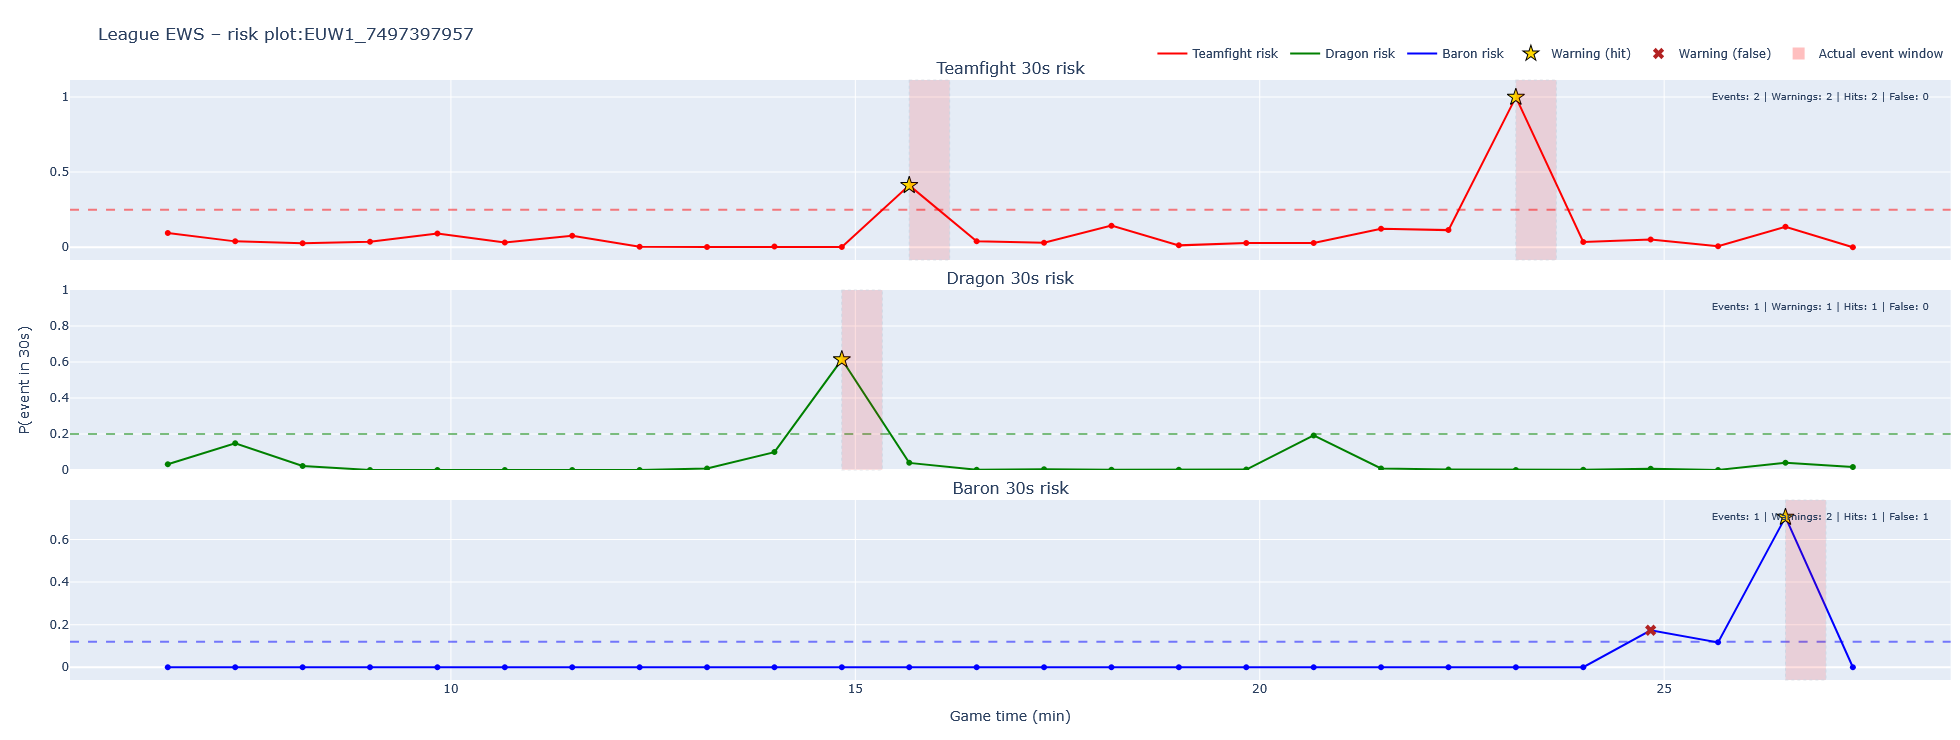

### **Sample 2:**

In [ ]:
plot_ews_dashboard("EUW1_7564257918")

Using match: EUW1_7564257918


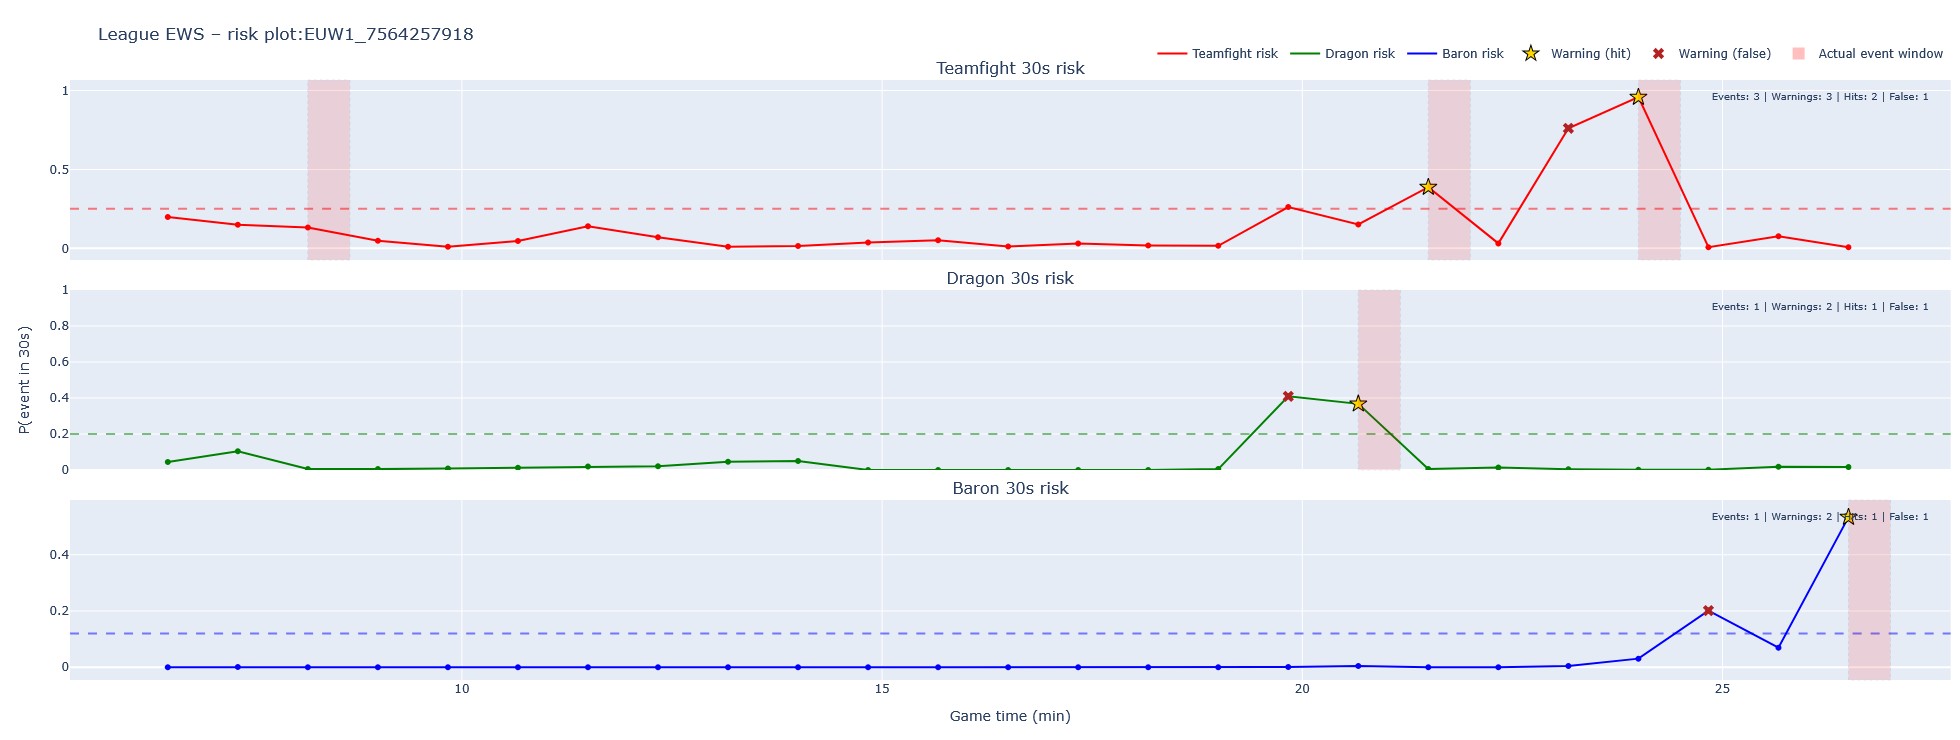

### **Sample 3:**

In [ ]:
plot_ews_dashboard("EUW1_7579203833")

Using match: EUW1_7579203833


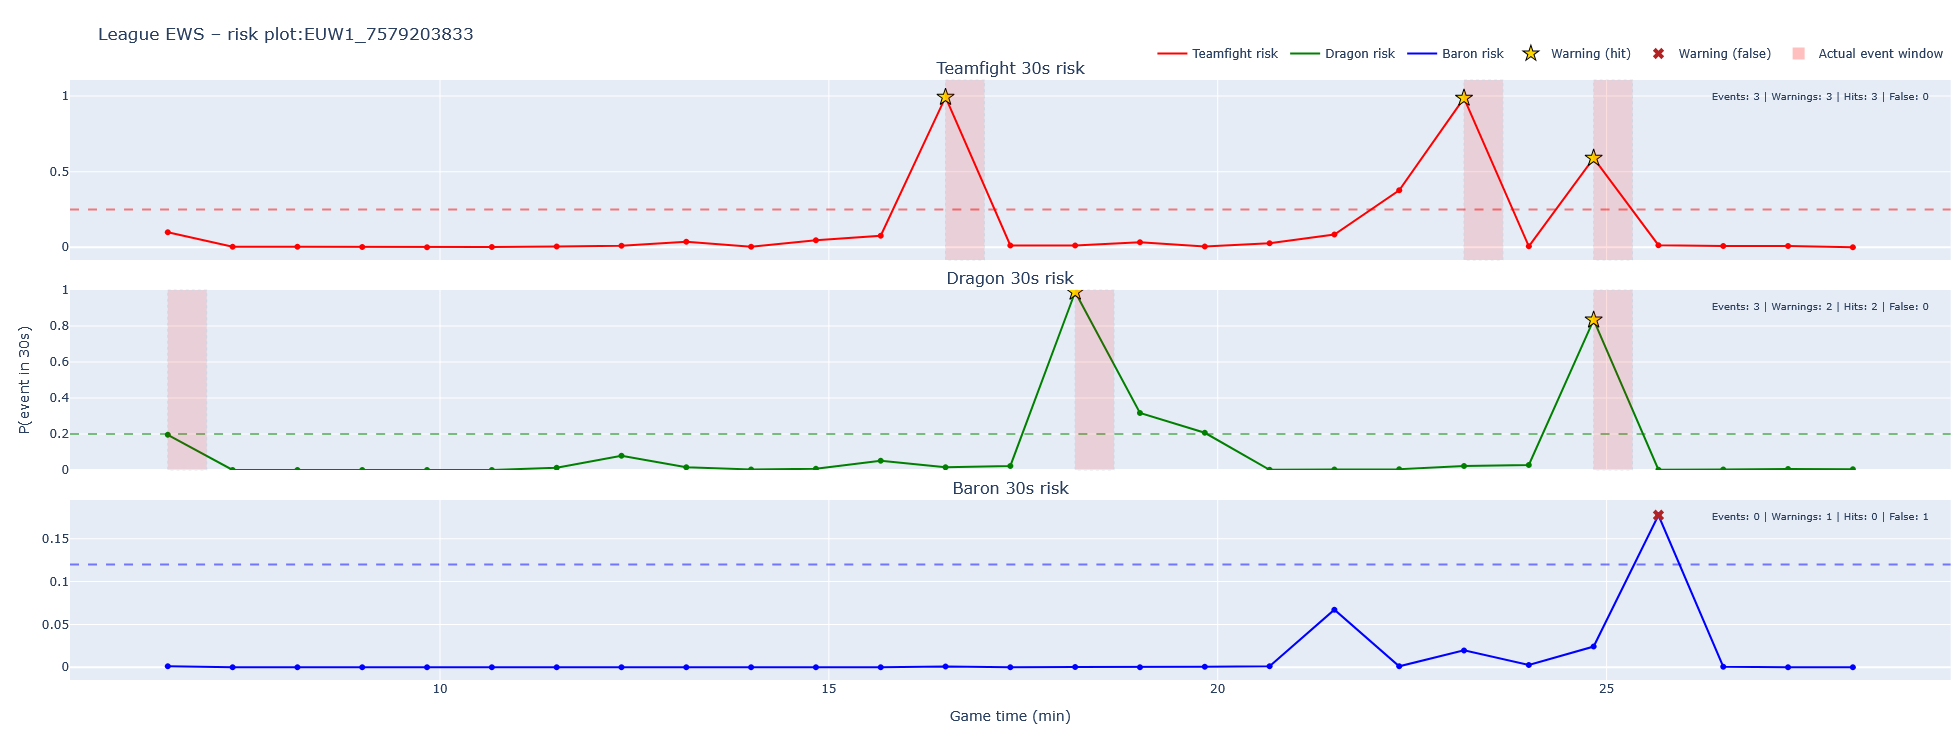

### **Sample 4:**

In [ ]:
plot_ews_dashboard("EUW1_7584511607")

Using match: EUW1_7584511607


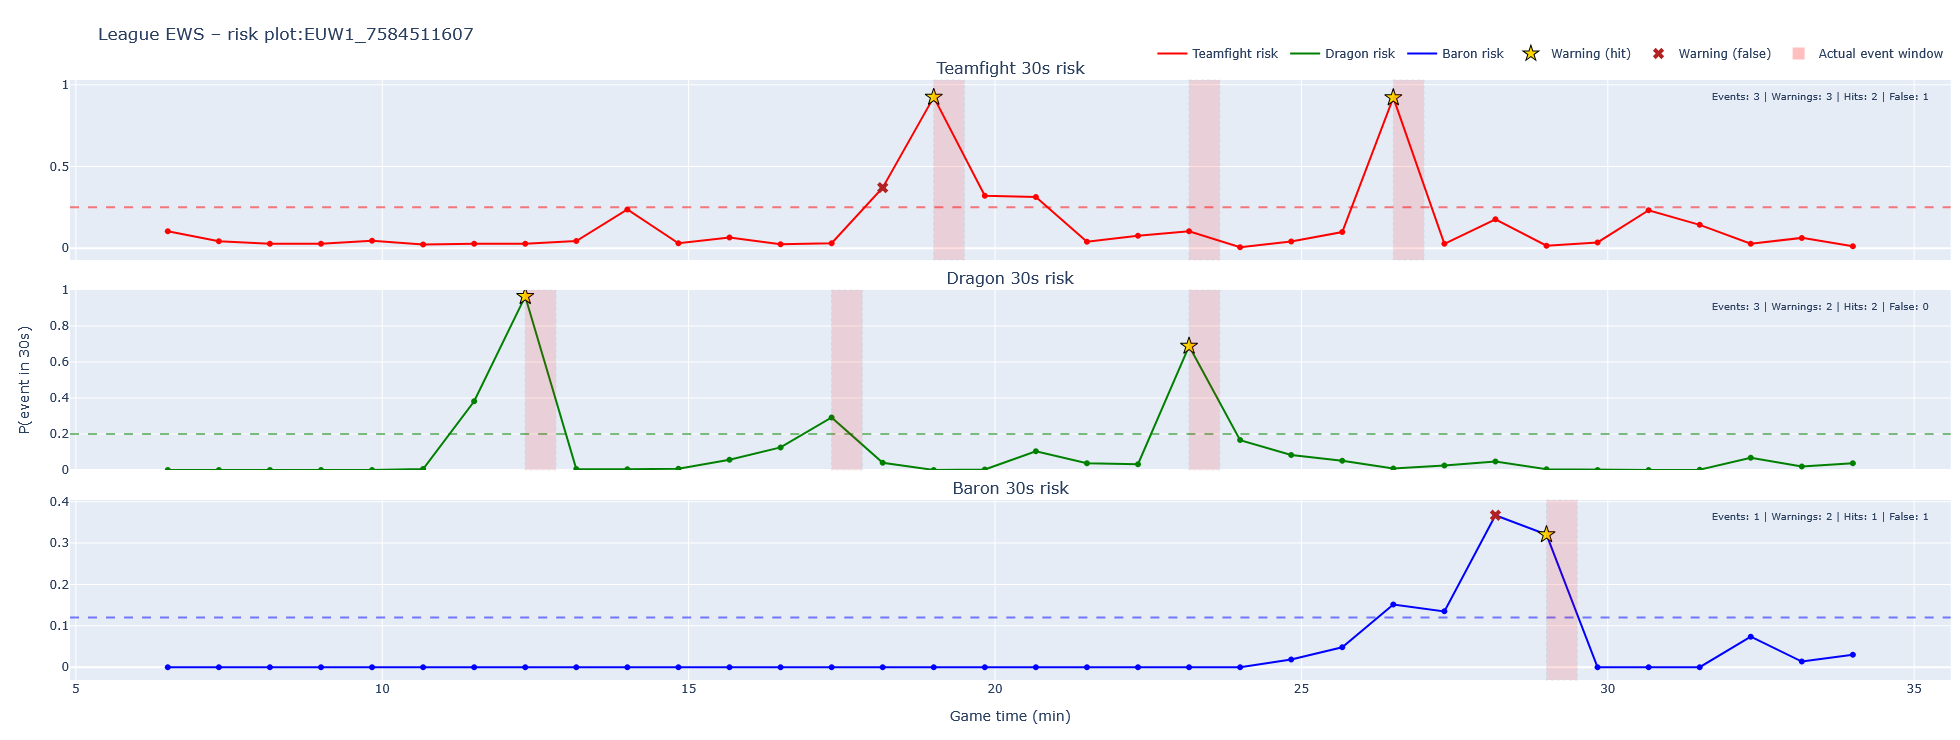

* The function extracts sequential windows, applies the LeagueEWS architecture, and generates continuous 30-second hazard curves for Teamfight, Dragon, and Baron events across the full game timeline.
* Each event stream is evaluated against a calibrated probability floor and passed through the clustering-based warning selector, producing stable alerts that avoid jitter and redundant triggers while preserving responsiveness.
* Actual event windows are rendered directly on the plot, enabling immediate visual comparison between predicted risk surges and real occurrences at 30-second resolution.
* For every subplot, the dashboard annotates event count, warning count, number of hits, and false alarms, offering a compact performance summary for that match without additional computation.
* Running the function on multiple match IDs surfaces differences in pacing, volatility, and signal quality, supporting analysis of model behavior across objective control styles, team compositions, and tempo patterns.